# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## План реализации проекта

Разделим проект на несколько частей:

1. [Знакомство с данными. Импорт библиотек. Составление карты предобработки данных.](#step_1)
2. [Предобработка данных.](#step_2)
3. [Работа с таблицами.](#step_3)
4. [Исследовательский анализ данных. Ответы на поставленные в исследовании вопросы.](#step_4)


### Шаг 1. Откройте файл с данными и изучите общую информацию.  <a id='step_1'></a>

In [527]:
import pandas as pd
import matplotlib.pyplot as plt
from pymystem3 import Mystem

In [528]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [529]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

На этапе знакомства с данными предлагаю более конкретно сформулировать задачи:

1. 'first_day_exposition' - формат object. Перевести в timedata64 ±
2. 'ceiling_height' - имеет пропуски. Заполнить +
3. 'floors_total' - имеет пропуски. Заполнить. Перевести в int64 +
4. 'living_area' - имеет пропуски. Заполнить +
5. 'is_apartment' - имеет пропуски. Заполнить. Перевести в bool +
6. 'kitchen_area' - имеет пропуски. Заполнить +
7. 'balcony' - имеет пропуски. Заполнить +
8. 'locality_name' - имеет пропуски. Заполнить +
9. 'airports_nearest'- имеет пропуски. Заполнить. Перевести в int64 ±
10. 'cityCenters_nearest' - имеет пропуски. Заполнить. Перевести в int64 +
11. 'parks_around3000' - имеет пропуски. Заполнить. Перевести в int64 +
12. 'parks_nearest' - имеет пропуски. Заполнить. Перевести в int64 +
13. 'ponds_around3000' - имеет пропуски. Заполнить. Перевести в int64 +
14. 'ponds_nearest' - имеет пропуски. Заполнить. Перевести в int64 +
15. 'days_exposition' - имеет пропуски. Заполнить. Перевести в int64 +

Посмотрим на верхушку датафрейма

In [530]:
pd.set_option('display.max_columns', 100)

In [531]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Видим пропущеные значения в разных столбцах. Но в целом все выглядит ок. Копнем чуть глубже и посмотрим на describe каждого из столбцов 

In [532]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Дополним задачи:
16. 'last_price' - минимальная цена 12190 руб. Посмотреть почему и как много таких объявлений
17. 'ceiling_height' - минимальная высота потолков 1м, максимальная 100м. Странно. И стандартное отклонение в 1,26 великовато. Посмотреть

Остальные данные выглядят ок.

### Вывод

Данные проанализированы. Составлена план-карта предобработки данных. Серьезных выбросов и проблем на данный момент не зафиксировано. Можно приступать к предобработке.

### Шаг 2. Предобработка данных<a id='step_2'></a>

#### 1. Столбец 'first_day_exposition' предобработка

Начнем по порядку. Переведем 'first_day_exposition' в формат даты

In [533]:
data.first_day_exposition = pd.to_datetime(data.first_day_exposition, format='%Y-%m-%dT%H:%M:%S')

In [534]:
data.tail(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23694,9,9700000.0,133.81,2017-03-21,3,3.7,5.0,73.3,3,NaN,False,False,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15,3,NaN,5.0,38.0,4,NaN,False,False,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3.0,29.7,1,NaN,False,False,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28,2,3.0,17.0,NaN,12,NaN,False,False,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23698,4,1350000.0,32.30,2017-07-21,1,2.5,5.0,12.3,1,NaN,False,False,9.00,NaN,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [535]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_a

Ок. Формат данных изменился. Но мы потеряли время продажи. Разберемся с этим позже

#### 2. Столбец 'ceiling_hight' предобработка <a id='seiling_hight'></a>

Данный столбец имеет пропуски. Посмотрим на них:

In [536]:
data['ceiling_height'].value_counts(dropna=False)

NaN      9195
2.50     3515
2.60     1646
2.70     1574
3.00     1112
         ... 
26.00       1
3.88        1
3.29        1
3.83        1
3.58        1
Name: ceiling_height, Length: 184, dtype: int64

Более 40% объявлений не имеют данных о высоте потолка. Это много. При этом, любая недвижимость имеет этот параметр. Поэтому заполнить данные нужно обязательно. Посмотрим какая взаимосвязь у этого параметра с другими. Построим матрицу корреляции. 

Очевидно, что мы не ожидаем увидеть корреляции между высотой потолка и количеством парков вокруг. А вот между высотой потолка и ценой - очень может быть. Если это окажется так, то заполнять пропуски придется гораздо более вдумчиво, так как неверный метод заполнения может оказать сильное влияние на основной параметр оценки недвижимости - цену. 

In [537]:
data.corr().head(5)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_images,1.000000,0.104473,0.115352,0.099288,-0.001987,0.010427,0.104780,0.031340,-0.029303,-0.024407,0.104756,0.121693,-0.002298,-0.047666,0.021120,-0.008347,-0.011553,-0.003034,-0.026657
last_price,0.104473,1.000000,0.653675,0.363343,0.085430,-0.006984,0.566492,0.026576,-0.025362,-0.008802,0.519869,0.029646,-0.026239,-0.206747,0.151058,-0.016414,0.159996,-0.084809,0.081146
total_area,0.115352,0.653675,1.000000,0.758344,0.095490,-0.075774,0.939537,-0.024754,-0.072653,-0.034885,0.609121,0.047937,-0.030753,-0.231446,0.164689,-0.021497,0.162346,-0.097969,0.149675
rooms,0.099288,0.363343,0.758344,1.000000,0.054457,-0.228215,0.845977,-0.150862,-0.147286,-0.087500,0.269945,0.017991,-0.061199,-0.184864,0.137257,-0.054549,0.092693,-0.057689,0.126961
ceiling_height,-0.001987,0.085430,0.095490,0.054457,1.000000,-0.028732,0.090650,-0.011798,0.001674,0.042777,0.087641,0.040523,-0.023947,-0.091689,0.065915,-0.019167,0.078209,-0.059090,0.019091


Как видно из матрицы корреляции - у высоты потолка нет даже слабой связи с каким либо параметром. Первый зеленый свет к заполнению пустых значений 'ceiling_height' получен. Но нужно копнуть глубже. Здравый смысл подсказывает, что хотябы слабая корреляция с ценой должна быть!

Посмотрим на разброс значений

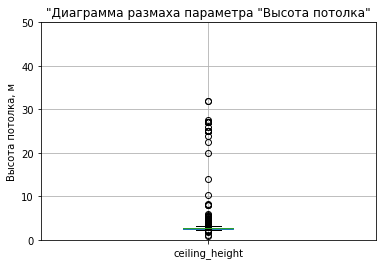

In [538]:
ch_bxp_1 = data.boxplot('ceiling_height')
ch_bxp_1.set_title('"Диаграмма размаха параметра "Высота потолка"')
ch_bxp_1.set_ylabel('Высота потолка, м')
plt.ylim(0,50)
plt.show()

Удивительно, но есть скопление точек в районе 20 - 35 метров. Для жилой недвижимости это очень странно. Близко к невозможному. Посмотрим на эти данные

In [539]:
len(data.query('ceiling_height > 19'))

23

In [540]:
data.query('ceiling_height > 19').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000.0,55.2,2018-07-12,2,25.0,5.0,32.0,2,False,False,False,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2900000.0,75.0,2018-11-12,3,32.0,3.0,53.0,2,NaN,False,False,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4643,0,4300000.0,45.0,2018-02-01,2,25.0,9.0,30.0,2,NaN,False,False,7.0,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000.0,25.0,2017-09-27,0,27.0,25.0,17.0,17,NaN,False,True,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3850000.0,30.5,2018-10-03,1,24.0,5.0,19.5,1,True,False,False,5.5,NaN,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0


Всего 23 подобных объявления. При этом другие параметры особо не выделяются на фоне остальных объявлений. Скорее всего, люди просто допустили опечатку, поставив разделитель в другом месте. Передвинув запятую, получим адекватный метраж - 2.5, 2.7 и т.д. Таких объявлений всего 0,09% от общего числа. Но в интересах учебного проекта отбрасывать их не будем. Исправим выстоту потолка и включим объявления в общую статистику

In [541]:
data.loc[data['ceiling_height'] > 19, 'ceiling_height'] = data.loc[data['ceiling_height'] > 19, 'ceiling_height'] / 10

Посмотрим на разброс теперь:

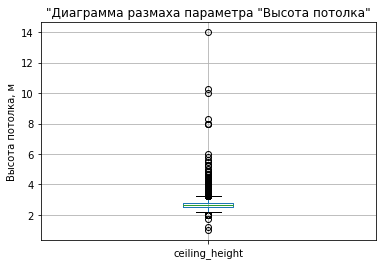

In [542]:
ch_bxp_2 = data.boxplot('ceiling_height')
ch_bxp_2.set_title('"Диаграмма размаха параметра "Высота потолка"')
ch_bxp_2.set_ylabel('Высота потолка, м')
plt.show()

Ок. Всего несколько значений сильно отклоняются от, на мой взгляд, адекватных 5 метров. И есть несколько значений ниже 2 метров. Посмотрим всего сколько их осталось

In [543]:
len(data.query('ceiling_height > 5 | ceiling_height < 2'))

17

Всего 17 объявлений. Объяснить природу их появления уже сложнее. В целом, мы ничего не потеряем если их просто отбросим. Позже

Для лучшего понимания связи 'ceiling_height' и 'last_price' сведем их в один датафрейм и построим график зависимости 

In [544]:
corr_pr_he = data.pivot_table(index='ceiling_height', values='last_price')

Text(0, 0.5, 'Цена квартиры, 100млн. руб')

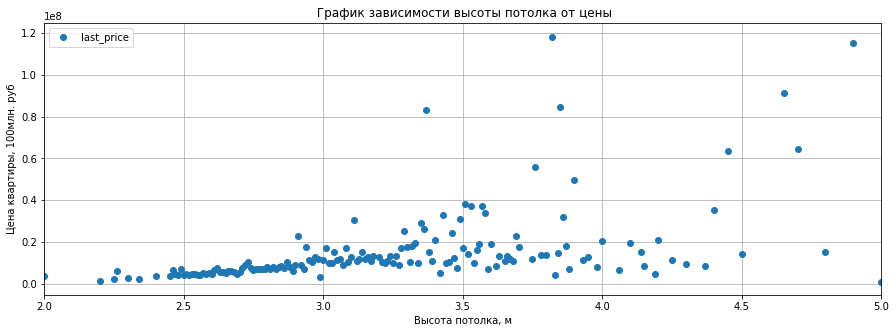

In [545]:
hist_lp_ch = corr_pr_he.plot(y='last_price', style='o', grid=True, xlim=(2, 5), title=' График зависимости высоты потолка от цены', figsize=(15, 5))
hist_lp_ch.set_xlabel('Высота потолка, м')
hist_lp_ch.set_ylabel('Цена квартиры, 100млн. руб')

Здесь невооруженным вглядом видна искомая нами корреляция до значений высоты потолка ~ 3,2м. Дальше появляется сильный разброс. Для оценки величины коэффициента корреляции Пирсона предлагаю брать значения 'ceiling_heights' меньше 3,2 метров. Львиная доля жилой недвижимости (более 50%) располагается именно в этом диапазоне

In [546]:
data.query('ceiling_height < 3.2')['last_price'].corr(data.query('ceiling_height < 3.2')['ceiling_height'])

0.36073439043814187

Да, теперь между данными наблюдается слабо выраженная корреляция. Предлагаю использовать это значение как мерило корректности заполнения пропусков. Если после заполнения КК останется ± прежним, значит мы как минимум не сделали хуже.

Заполнять пропуски будем медианным значенем.

In [547]:
data.ceiling_height.describe()

count    14504.000000
mean         2.729608
std          0.319850
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         14.000000
Name: ceiling_height, dtype: float64

In [548]:
data['ceiling_height'] = data['ceiling_height'].fillna(2.65)

In [549]:
data.ceiling_height.describe()

count    23699.000000
mean         2.698721
std          0.253208
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

Отлично, все пропущенные значения заполнили медианными значениями. Посмотрим как изменился коэффициент корреляции

In [550]:
data.query('ceiling_height < 3.2')['last_price'].corr(data.query('ceiling_height < 3.2')['ceiling_height'])

0.1990067146747744

Коэффициент корреляции ожидаемо упал. Лучше было бы заполнить пустые значения по некоторому закону, чтобы точки легли на линию регрессии. Пока оставим все как есть. Далее по проекту, если нам потребуются значения 'ceiling_height' для более точного результата - вернемся.

#### 3. Столбец 'floors_total' предобработка

Данные об общем количестве этажей имеют ряд неточностей.  
1. Посмотрим, какая доля пропущена
2. Заполним пропуски
3. Поменяем тип данных на int64

Узнаем количество пропущеных значений

In [551]:
data['floors_total'].value_counts(dropna=False).tail(15)

11.0    203
27.0    164
21.0    158
26.0    124
NaN      86
1.0      25
35.0     24
28.0     21
36.0      3
29.0      1
60.0      1
33.0      1
52.0      1
37.0      1
34.0      1
Name: floors_total, dtype: int64

86 - не много. Посмотрим на гистаграмму распределения значений. Зададим максимальный размер в 30 этажей. 

Text(0, 0.5, 'Частота встречаемости')

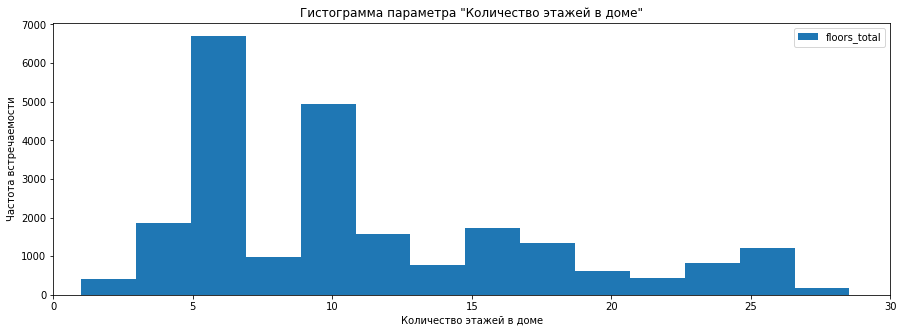

In [552]:
hist_fltot_1 = data.plot(y='floors_total', kind='hist', bins=30, xlim=(0, 30), title = 'Гистограмма параметра "Количество этажей в доме"', figsize=(15, 5))
hist_fltot_1.set_xlabel('Количество этажей в доме')
hist_fltot_1.set_ylabel('Частота встречаемости')

Ожидаемый пик на 5-ке. Это объясняется большим количеством панельных хрущевок расположенных как по всей России в целом, так и в Ленинградской области в частности. Чуть меньший пик на 9-ке скорее всего соответствует более поздним постройкам, в основном "брежневкам". График уползает вправо характеризуя бурный рост современных многоэтажных комплексов. В целом, 2 выделяющихся пика - это в основном дома типовой застройки советсткого периода. 

Причина возникновения пропусков кроется, возможно, в человеческом факторе. Нулевым значение априори быть не может. Скорее всего человек просто не указал данные о количестве этажей

В качестве замещающих значений корректнее будет взять величину средней этажности. Это объясняется тем, что обычно, медианным значением пользуются в случае наличия в данных разного рода выбросов, которые влияют на среднее. Медиана в таких случаях лучше отражает действительность. В нашем же случае - более 99% всех данных находятся в адкватных пределах. Есть несколько выбросов, но столь незначительных, что их влиянием на среднее можно пренебречь. И так как среднее в себе содержит все имеющиеся данные этажности - оно лучше отражает реальную среднюю этажность. 

In [553]:
data['floors_total'].mean()

10.67382374115953

Проверим количество аномально высоких значений с тем, чтобы знать как они могут повлиять на среднее.

Самым высоким жилым зданием на территории Ленинградской области по информации "Википедии" является ЖК "Князь Александр Невский". Комплекс имеет 37 этажей. Возьмем это как верхнюю границу. Все что выше - будем считать выбросами

In [554]:
data.query('floors_total > 37')['floors_total'].count()

2

In [555]:
data.query('floors_total > 37')['floors_total'].max()

60.0

Всего 2 значения. Максимальное из которых - 60. Конечно, они не окажут какого-либо заметного влияния на среднее.

Заполним пустые значения:

In [556]:
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].mean())

In [557]:
data['floors_total'].describe()

count    23699.000000
mean        10.673824
std          6.585192
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Все данные на месте. Заменим тип float64 на int64

In [558]:
data['floors_total'] = data['floors_total'].astype(int)

In [559]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_aro

Работу над столбцом 'floors_total' мы закончили. Переходим к 'living_area'

#### 4. Столбец 'living_area' предобработка

Здесь с типом данных все в порядке. Нужно только разобраться с пропусками

In [560]:
data['living_area'].value_counts(dropna=False)

NaN      1903
18.00     882
17.00     675
30.00     598
16.00     486
         ... 
10.55       1
24.83       1
20.03       1
20.97       1
15.55       1
Name: living_area, Length: 1783, dtype: int64

1903 - пропуска это почти 10%. Поступим так же как и с предыдущим столбцом - потроим для начала график распределения:

Text(0, 0.5, 'Частота встречаемости')

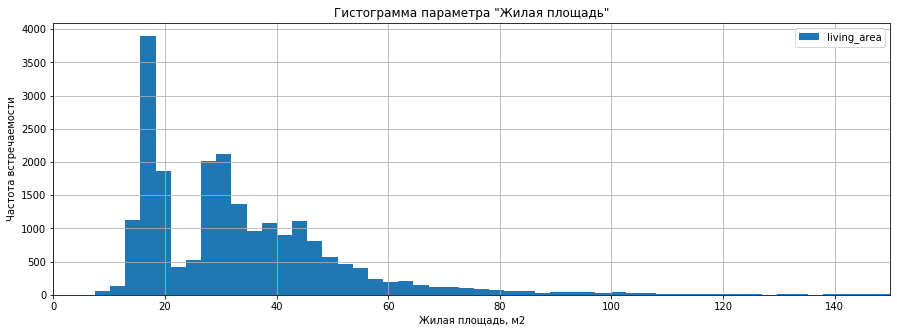

In [561]:
hist_lvar_1 = data.plot(y='living_area', kind='hist', xlim=(0, 150), bins=150, title = 'Гистограмма параметра "Жилая площадь"', grid=True, figsize=(15, 5))
hist_lvar_1.set_xlabel('Жилая площадь, м2')
hist_lvar_1.set_ylabel('Частота встречаемости')

Больше всего квартир общей жилой площадью 18-20м2 и около 30м2

Для того, чтобы понять чем заполнить пропуски посмотрим на взаимосвязь этой переменной с другими:

In [562]:
data.corr().head(10)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_images,1.000000,0.104473,0.115352,0.099288,0.050128,0.010694,0.104780,0.031340,-0.029303,-0.024407,0.104756,0.121693,-0.002298,-0.047666,0.021120,-0.008347,-0.011553,-0.003034,-0.026657
last_price,0.104473,1.000000,0.653675,0.363343,0.256458,-0.006989,0.566492,0.026576,-0.025362,-0.008802,0.519869,0.029646,-0.026239,-0.206747,0.151058,-0.016414,0.159996,-0.084809,0.081146
total_area,0.115352,0.653675,1.000000,0.758344,0.342083,-0.075647,0.939537,-0.024754,-0.072653,-0.034885,0.609121,0.047937,-0.030753,-0.231446,0.164689,-0.021497,0.162346,-0.097969,0.149675
rooms,0.099288,0.363343,0.758344,1.000000,0.211263,-0.227743,0.845977,-0.150862,-0.147286,-0.087500,0.269945,0.017991,-0.061199,-0.184864,0.137257,-0.054549,0.092693,-0.057689,0.126961
ceiling_height,0.050128,0.256458,0.342083,0.211263,1.000000,-0.073526,0.330304,-0.039064,0.009109,-0.001865,0.299071,-0.010558,-0.072740,-0.257594,0.197492,-0.054342,0.166407,-0.101690,0.096314
floors_total,0.010694,-0.006989,-0.075647,-0.227743,-0.073526,1.000000,-0.169135,0.674878,0.069309,0.050810,0.163676,0.194389,0.107934,0.019615,-0.252311,0.097102,-0.122591,0.038873,-0.052126
living_area,0.104780,0.566492,0.939537,0.845977,0.330304,-0.169135,1.000000,-0.097210,-0.056231,-0.033711,0.428674,0.018849,-0.057912,-0.231368,0.184453,-0.050167,0.148933,-0.081674,0.142454
floor,0.031340,0.026576,-0.024754,-0.150862,-0.039064,0.674878,-0.097210,1.000000,0.036940,0.035824,0.135531,0.168773,0.071597,0.009084,-0.163784,0.073045,-0.076312,0.024850,-0.039463
studio,-0.029303,-0.025362,-0.072653,-0.147286,0.009109,0.069309,-0.056231,0.036940,1.000000,-0.004235,NaN,0.031455,-0.021876,-0.007029,-0.030202,0.009134,0.000939,0.002606,-0.022476
open_plan,-0.024407,-0.008802,-0.034885,-0.087500,-0.001865,0.050810,-0.033711,0.035824,-0.004235,1.000000,NaN,0.019491,-0.013583,-0.004204,-0.010077,0.010612,0.008455,-0.003328,-0.024112


Мы видим очень сильную корреляцию с общей площадью 'total_area' и количеством комнат 'rooms'. Среднюю корреляцию с ценой продажи 'last_price' и площадью кухни 'kitchen_area'.

Построим диаграмму рассеяния с тем, чтобы сравнить ее с аналогичной после замены значений<a id='scatter_1'></a>

Text(0, 0.5, 'Жилая площадь, м2')

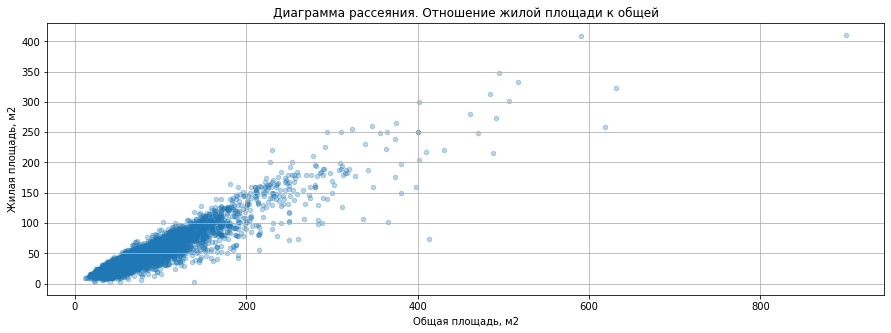

In [563]:
scat_totliv_1 = data.plot(x='total_area', y='living_area', kind='scatter', title = 'Диаграмма рассеяния. Отношение жилой площади к общей', grid=True, alpha=0.3, figsize=(15, 5))
scat_totliv_1.set_xlabel('Общая площадь, м2')
scat_totliv_1.set_ylabel('Жилая площадь, м2')

Отфильтруем значения. Оставим строки где пропущены значения жилой площади, и посмотрим на значения 'total_area' и 'rooms'. Возможно существует некая закономерность которая поможет заполнить пропуски

In [564]:
data.loc[data['living_area'].isna()].head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
7,5,7915000.0,71.6,2019-04-18,2,2.65,24,NaN,22,NaN,False,False,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
30,12,2200000.0,32.8,2018-02-19,1,2.65,9,NaN,2,NaN,False,False,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,10,1990000.0,45.8,2017-10-28,2,2.50,5,NaN,1,NaN,False,False,NaN,NaN,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
44,13,5350000.0,40.0,2018-11-18,1,2.65,22,NaN,3,NaN,False,False,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
59,15,6300000.0,46.5,2017-03-06,1,2.65,13,NaN,13,NaN,False,False,NaN,NaN,Санкт-Петербург,11125.0,14501.0,0.0,NaN,0.0,NaN,336.0
60,3,2740000.0,35.0,2018-01-01,1,2.65,12,NaN,8,NaN,False,False,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,11.0
81,9,10949000.0,68.0,2018-12-27,1,2.65,10,NaN,6,NaN,False,False,NaN,NaN,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,3,4500000.0,80.5,2018-01-15,3,2.65,25,NaN,16,NaN,False,False,NaN,NaN,посёлок Шушары,12430.0,18217.0,0.0,NaN,0.0,NaN,60.0
116,18,10999000.0,97.2,2017-11-13,3,2.50,16,NaN,16,NaN,False,False,18.3,5.0,Санкт-Петербург,19426.0,21138.0,0.0,NaN,2.0,390.0,394.0


Видно, что общая площадь у большинства (а может у всех) подобных объявлений есть. Какой либо нормы - как минимальной доли жилой площади в общей площади мне найти не удалось. В таком случае, вижу целесообразным вычислить "практически" на основании имеющихся данных - какую в среднем долю занимает жилая площадь. Для этого для кажого объявления разделим 'total_area' на 'living_area' и найдем среднее. На полученное значение и будем делить 'total_area' для данных без известной площади 'living_area'

Для расчетов создадим новый датафрейм area_stat

In [565]:
area_stat = data[['total_area', 'living_area']]

In [566]:
area_stat.head()

,total_area,living_area
0,108.0,51.0
1,40.4,18.6
2,56.0,34.3
3,159.0,NaN
4,100.0,32.0


Создадим новый столбец 'area_ratio' где вычислим отношение значений из двух столбцов

In [567]:
area_stat['area_ratio'] = area_stat['total_area'] / area_stat['living_area']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Вычислим среднее

In [568]:
area_stat['area_ratio'].mean()

1.8464700489680814

Отлично! Теперь разделим 'total_area' для строк с неизвестным 'living_area' на 1,85 и заполним пропуски полученными значениями

In [569]:
data.loc[data['living_area'].isna(), 'living_area'] = data.loc[data['living_area'].isna(), 'total_area'] / 1.85

Смотрим на количество пропущеных значений:

In [570]:
data['living_area'].isna().sum()

0

Ни одного значения не осталось! Посмотрим на то как изменилась гистограмма распределения, коэффициент корреляции, и диаграмма рассеяния

Text(0, 0.5, 'Частота встречаемости')

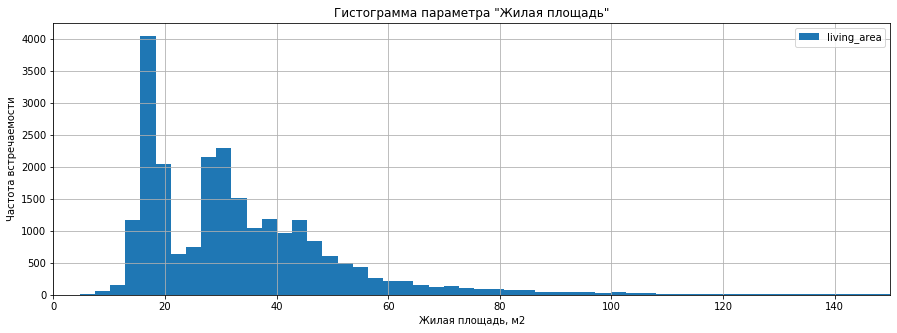

In [571]:
hist_lvar_1 = data.plot(y='living_area', kind='hist', xlim=(0, 150), bins=150, title = 'Гистограмма параметра "Жилая площадь"', grid=True, figsize=(15, 5))
hist_lvar_1.set_xlabel('Жилая площадь, м2')
hist_lvar_1.set_ylabel('Частота встречаемости')

График ожидаемо "вырос" по всей своей длине, но сохранил форму. Смотрим корреляцию

In [572]:
data.corr().head(10)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_images,1.000000,0.104473,0.115352,0.099288,0.050128,0.010694,0.104226,0.031340,-0.029303,-0.024407,0.104756,0.121693,-0.002298,-0.047666,0.021120,-0.008347,-0.011553,-0.003034,-0.026657
last_price,0.104473,1.000000,0.653675,0.363343,0.256458,-0.006989,0.584961,0.026576,-0.025362,-0.008802,0.519869,0.029646,-0.026239,-0.206747,0.151058,-0.016414,0.159996,-0.084809,0.081146
total_area,0.115352,0.653675,1.000000,0.758344,0.342083,-0.075647,0.944700,-0.024754,-0.072653,-0.034885,0.609121,0.047937,-0.030753,-0.231446,0.164689,-0.021497,0.162346,-0.097969,0.149675
rooms,0.099288,0.363343,0.758344,1.000000,0.211263,-0.227743,0.828908,-0.150862,-0.147286,-0.087500,0.269945,0.017991,-0.061199,-0.184864,0.137257,-0.054549,0.092693,-0.057689,0.126961
ceiling_height,0.050128,0.256458,0.342083,0.211263,1.000000,-0.073526,0.327916,-0.039064,0.009109,-0.001865,0.299071,-0.010558,-0.072740,-0.257594,0.197492,-0.054342,0.166407,-0.101690,0.096314
floors_total,0.010694,-0.006989,-0.075647,-0.227743,-0.073526,1.000000,-0.160088,0.674878,0.069309,0.050810,0.163676,0.194389,0.107934,0.019615,-0.252311,0.097102,-0.122591,0.038873,-0.052126
living_area,0.104226,0.584961,0.944700,0.828908,0.327916,-0.160088,1.000000,-0.089872,-0.056457,-0.025221,0.435192,0.018520,-0.052548,-0.229478,0.179240,-0.049633,0.148206,-0.083762,0.145112
floor,0.031340,0.026576,-0.024754,-0.150862,-0.039064,0.674878,-0.089872,1.000000,0.036940,0.035824,0.135531,0.168773,0.071597,0.009084,-0.163784,0.073045,-0.076312,0.024850,-0.039463
studio,-0.029303,-0.025362,-0.072653,-0.147286,0.009109,0.069309,-0.056457,0.036940,1.000000,-0.004235,NaN,0.031455,-0.021876,-0.007029,-0.030202,0.009134,0.000939,0.002606,-0.022476
open_plan,-0.024407,-0.008802,-0.034885,-0.087500,-0.001865,0.050810,-0.025221,0.035824,-0.004235,1.000000,NaN,0.019491,-0.013583,-0.004204,-0.010077,0.010612,0.008455,-0.003328,-0.024112


На несколько сотых долей выросла взаимосвязь между рассматриваемыми величинами. Все в рамках приличия. С уверенностью можно сказать, связь переменных осталась практически без изменений. Значит, угрозы для корректности дальнейшего анализа такая замена не несет)

Построим итоговую диаграмму рассеяния и сравним с [той](#scatter_1), что была до замены значений

Text(0, 0.5, 'Жилая площадь, м2')

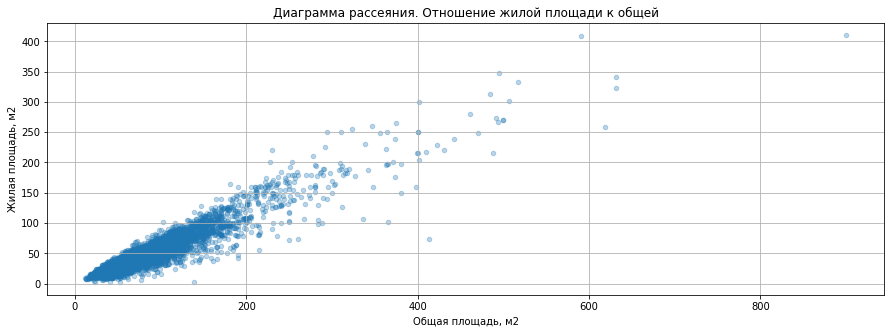

In [573]:
scat_totliv_1 = data.plot(x='total_area', y='living_area', kind='scatter', title = 'Диаграмма рассеяния. Отношение жилой площади к общей', grid=True, alpha=0.3, figsize=(15, 5))
scat_totliv_1.set_xlabel('Общая площадь, м2')
scat_totliv_1.set_ylabel('Жилая площадь, м2')

Графики идентичны. Нет заметных выбросов которые отличались бы у обоих графиков. Это подтверждает корректность произведенным нами заполнений

#### 5. Столбец 'is_apartment' предобработка

Мы знаем, что количество имеющихся значений в этом столбце ~10%. Посмотрим на уникальные значения

In [574]:
data['is_apartment'].value_counts(dropna=False)

NaN      20924
False     2725
True        50
Name: is_apartment, dtype: int64

Всего 50 объявлений. Не много. Посмотрим на объявления о продаже апартаментов "глазами". Возможно, они чем-то отличаются от остальных

In [575]:
data.query('is_apartment == True').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
543,11,12790000.0,56.6,2018-11-06,2,3.50,3,29.400000,1,True,False,False,NaN,NaN,Петергоф,35248.0,30437.0,3.0,53.0,3.0,22.0,NaN
916,11,8183000.0,70.0,2018-01-11,2,3.12,3,40.000000,3,True,False,False,NaN,2.0,Санкт-Петербург,45796.0,21729.0,0.0,NaN,1.0,754.0,179.0
1109,1,34878556.0,95.8,2014-12-09,2,2.65,6,58.300000,5,True,False,False,20.00,1.0,Санкт-Петербург,21860.0,318.0,2.0,160.0,3.0,569.0,1572.0
1608,12,2150000.0,20.1,2019-01-30,1,2.65,9,10.864865,1,True,False,False,NaN,NaN,Санкт-Петербург,26646.0,12147.0,0.0,NaN,0.0,NaN,13.0
2759,11,7500000.0,152.0,2018-07-27,3,3.00,3,82.162162,1,True,False,False,NaN,1.0,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,7.0
2975,9,4931398.0,42.9,2018-07-23,1,3.15,4,20.390000,3,True,False,False,10.29,NaN,Санкт-Петербург,44870.0,20802.0,0.0,NaN,1.0,792.0,273.0
3067,13,6600000.0,95.0,2018-09-08,2,4.50,7,45.000000,7,True,False,False,25.00,2.0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,96.0
3816,4,4779000.0,53.1,2016-05-16,1,2.65,13,19.800000,6,True,False,False,15.90,2.0,Санкт-Петербург,19396.0,4516.0,0.0,NaN,1.0,826.0,60.0
3951,10,4300000.0,50.0,2019-04-20,1,3.00,11,17.000000,9,True,False,False,12.00,2.0,Санкт-Петербург,10143.0,11367.0,0.0,NaN,0.0,NaN,NaN
4339,19,6900000.0,72.0,2019-03-25,3,3.50,4,70.000000,1,True,False,False,NaN,NaN,Санкт-Петербург,31487.0,4466.0,2.0,353.0,1.0,439.0,22.0


Данные **ничем не отличаются** от общей массы. 

*Возникло предположение, что тип 'is_apartment' может быть как-то связан с 'living_area', которую мы к этому моменту уже заполнили. Я вернулся в момент до преобразования 'living_area' и никакой связи не нашел*

По результатам исследования данных, какого либо отличительного признака у квартир типа "апартаменты" не выявлено. 
Для оценки возможной реальной доли апартаментов в общем количестве объявлений, я полез серфить.
Согласно сайту Яндекс.Недвижимость количество объявлений в ЛО в категории "вторичное жилье и новостройки" ~ 39500. При этом количество апартаментов ~ 2400. Что соответствует доле ~ 6%. Именно столько места, на сегодня, апартаменты занимают в общем объеме недвижимости. 

Таким образом, мы признаем, что часть наших объявлений (~6%) принадлежит к категории апартаменты, но какие именно объявления - нам неизвестно. Для ответа на поставленные в исследовании вопросы, нам не очень важна эта информация. Поэтому, мы можем себе позволить пожертвовать дальнейшей правдивостью этих данных и заполнить пропуски значением, например **False**.

In [576]:
data.loc[data['is_apartment'].isna(), 'is_apartment'] = False

In [577]:
data['is_apartment'].isnull().sum()

0

**Пропуски заполнены!**

#### 6. Столбец 'kitchen_area' предобработка

Посмотрим на количество пропущеных значений:

In [578]:
data['kitchen_area'].isnull().sum()

2278

Для выбора способа заполнения пропусков посмотрим на взаимосвязь этой переменной с другими:

In [579]:
data.corr()['kitchen_area']

total_images           0.104756
last_price             0.519869
total_area             0.609121
rooms                  0.269945
ceiling_height         0.299071
floors_total           0.163676
living_area            0.435192
floor                  0.135531
is_apartment           0.049034
studio                      NaN
open_plan                   NaN
kitchen_area           1.000000
balcony                0.098634
airports_nearest       0.008200
cityCenters_nearest   -0.190049
parks_around3000       0.087503
parks_nearest          0.029641
ponds_around3000       0.150148
ponds_nearest         -0.105223
days_exposition        0.100586
Name: kitchen_area, dtype: float64

Видим самый высокий показатель коррелиции с 'total_area'. 0,609 - соответствует значению взаимосвязи "выше среднего".
Согласно СНИП 31-01-2003 минимальный размер площади кухни - 6м2 для 1-ком. квартиры и 8м2 для 2-ком. квартиры и выше. Но если мы примем эти минимальные значения в качестве данных для заполнения пропусков, то коэффициент корреляции просядет. Объективнее будет поступить как с долей жилой площади: найти какую в среднем долю пространство кухни занимает в общей площади квартиры, и полученное значение домножить на общую площадь.

Предварительно посмотрим на гистограмму распределения кухонных площадей, и дополнительно визуально оценим связь с общей площадью квартиры <a id='scatter_2'></a>
                                                                                                      

Text(0, 0.5, 'Частота встречаемости')

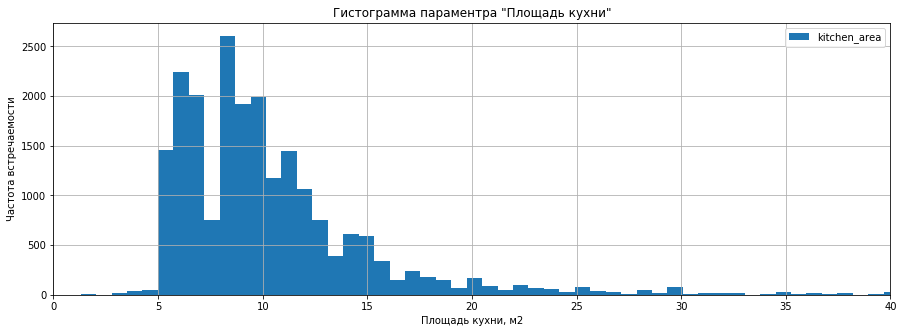

In [580]:
hist_kit_1 = data.plot(y='kitchen_area', kind='hist', bins=150, xlim=(0,40), title = 'Гистограмма параментра "Площадь кухни"', grid=True, figsize=(15, 5))
hist_kit_1.set_xlabel('Площадь кухни, м2')
hist_kit_1.set_ylabel('Частота встречаемости')

Построим отдельный датафрейм. Назовем **kitchen_stat** и сохраним в нем все интересующие нас для вычислений значения:                 

In [581]:
kitchen_stat = data.loc[~data['kitchen_area'].isna(), ['total_area', 'kitchen_area']]

Посмотрим, как визуально связаны два столбца между собой:

Text(0, 0.5, 'Площадь кухни, м2')

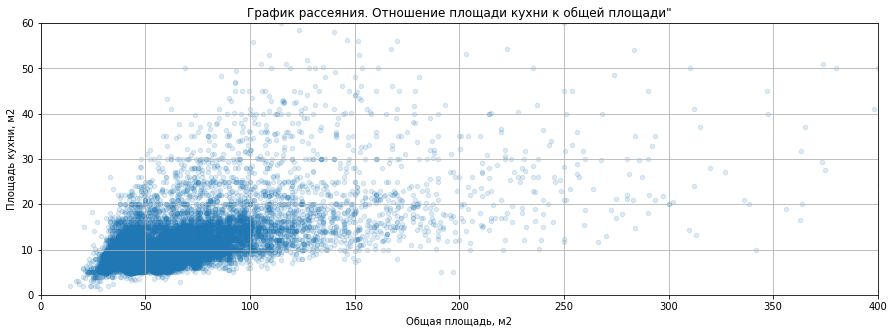

In [582]:
scat_kittot_1 = data.plot(x='total_area', y='kitchen_area', kind='scatter', xlim=(0, 400), ylim=(0, 60), alpha=0.15, title = 'График рассеяния. Отношение площади кухни к общей площади"', grid=True, figsize=(15, 5))
scat_kittot_1.set_xlabel('Общая площадь, м2')
scat_kittot_1.set_ylabel('Площадь кухни, м2')

Мы видим, что площадь кухни в большинстве случаев колеблется в диапазоне от 5м2 до 20м2 при общей площади квартиры от 20м2 до 120м2

Вычислим отношение общей площади к площади кухни и сохраним в отдельном столбце **'kitchen_ratio'**

In [583]:
kitchen_stat['kitchen_ratio'] = kitchen_stat['total_area'] / kitchen_stat['kitchen_area'] 

In [584]:
kitchen_stat.head()

,total_area,kitchen_area,kitchen_ratio
0,108.0,25.0,4.320000
1,40.4,11.0,3.672727
2,56.0,8.3,6.746988
4,100.0,41.0,2.439024
5,30.4,9.1,3.340659


In [585]:
kitchen_stat.mean()

total_area       60.749885
kitchen_area     10.569807
kitchen_ratio     6.133493
dtype: float64

Мы видим, что в среднем, площадь кухни занимает 6-ю часть общей площади квартиры. Разделим на эту величину площади квартир тех объявлений, где площадь кухни неизвестна и заполним пропуски.

In [586]:
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data['total_area'] / 6.13

Посмотрим теперь на количество пропущеных значений:

In [587]:
data['kitchen_area'].isna().sum()

0

Для дополнительной самопроверки построим графики для kitchen_area после заполнени пропуском и сравним с [изначальными](#scatter_2)

Text(0, 0.5, 'Частота встречаемости')

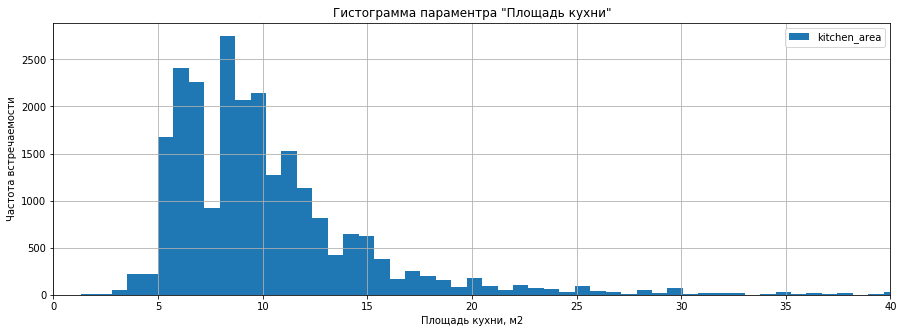

In [588]:
hist_kit_2 = data.plot(y='kitchen_area', kind='hist', bins=150, xlim=(0,40), title = 'Гистограмма параментра "Площадь кухни"', grid=True, figsize=(15, 5))
hist_kit_2.set_xlabel('Площадь кухни, м2')
hist_kit_2.set_ylabel('Частота встречаемости')

Text(0, 0.5, 'Площадь кухни, м2')

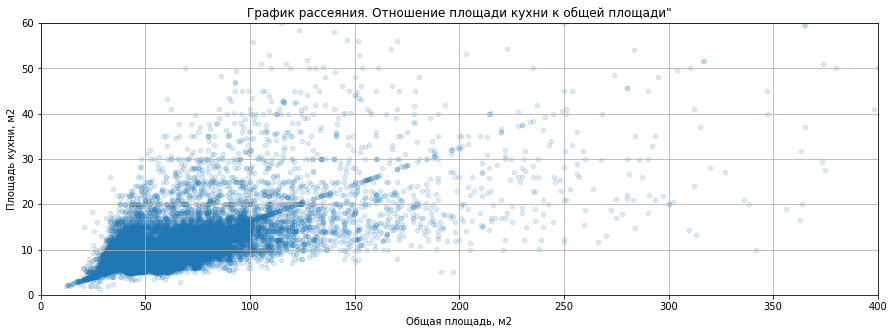

In [589]:
scat_kittot_2 = data.plot(x='total_area', y='kitchen_area', kind='scatter', xlim=(0, 400), ylim=(0, 60), alpha=0.15, title = 'График рассеяния. Отношение площади кухни к общей площади"', grid=True, figsize=(15, 5))
scat_kittot_2.set_xlabel('Общая площадь, м2')
scat_kittot_2.set_ylabel('Площадь кухни, м2')

На графике рассеяния хорошо заметно как значения легли на прямую выражающую отношение общей площади к кухонной. Посмотрим как изменился коэффициент корреляции:

In [590]:
data.corr()['kitchen_area']

total_images           0.111013
last_price             0.510818
total_area             0.657533
rooms                  0.325120
ceiling_height         0.289856
floors_total           0.122179
living_area            0.496573
floor                  0.107426
is_apartment           0.043637
studio                -0.078389
open_plan             -0.039136
kitchen_area           1.000000
balcony                0.085115
airports_nearest       0.007531
cityCenters_nearest   -0.192244
parks_around3000       0.099570
parks_nearest          0.021267
ponds_around3000       0.147009
ponds_nearest         -0.096221
days_exposition        0.114665
Name: kitchen_area, dtype: float64

Коэффициент корреляции  в среднем вырос на 0.01 - 0.06. Не критично для нашей задачи. **Считаем произведенное заполнение удачным**)

Возможные **причины появляения пропусков**: часто человек не знает точной площади своей кухни. Обычно на общий план квартиры наносится информация только об общей площади квартиры, жилой площади, и площади с учетом балкона. Площади отдельных комнат часто не указывают. Как померить самостоятельно кто-то может не знать, или не иметь под рукой инструмента для измерения.

Вторым возможным фактом является отсутствие четких границ помещения для обмера. Во многих квартирах можно встретить перепланировку. Например, часто объединяют кухонную зону и гостинную. И в таком случае, кухонная площадь может приписываться к площади гостинной. 

Подводя итог, - **основной причиной возникновения** здесь пропусков считаю **человеческий фактор**.

#### 6. Столбец 'balcony' предобработка

Смотрим количество пропущеных значений:

In [591]:
data['balcony'].isna().sum()

11519

Посмотрим на взаимосвязь с другими переменными:

In [592]:
data.corr()['balcony']

total_images           0.121693
last_price             0.029646
total_area             0.047937
rooms                  0.017991
ceiling_height        -0.010558
floors_total           0.194389
living_area            0.018520
floor                  0.168773
is_apartment           0.043119
studio                 0.031455
open_plan              0.019491
kitchen_area           0.085115
balcony                1.000000
airports_nearest       0.066834
cityCenters_nearest    0.051051
parks_around3000      -0.082850
parks_nearest          0.052328
ponds_around3000      -0.032709
ponds_nearest          0.010847
days_exposition       -0.032909
Name: balcony, dtype: float64

Даже слабой связи с какой-либо из переменных не наблюдается. Указание в инструкции по выполнение проекта обретает смысл - "если человек не указал число балконов — скорее всего, их нет. Такие пропуски правильно заменить на 0".

Посмотрим предварительно на график распределения величин:

Text(0, 0.5, 'Частота встречаемости')

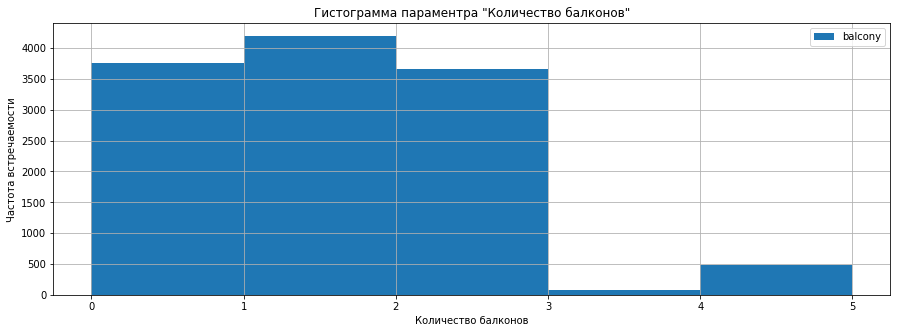

In [593]:
hist_bal_1 = data.plot(y='balcony', kind='hist', bins=5, title = 'Гистограмма параментра "Количество балконов"', grid=True, figsize=(15, 5))
hist_bal_1.set_xlabel('Количество балконов')
hist_bal_1.set_ylabel('Частота встречаемости')

Без лишних разговоров меняем все пропущеные значения на 0:

In [594]:
data.loc[data['balcony'].isna(), 'balcony'] = 0

In [595]:
data['balcony'].isna().sum()

0

Посмотрим на гистограмму распределения значений:

Text(0, 0.5, 'Частота встречаемости')

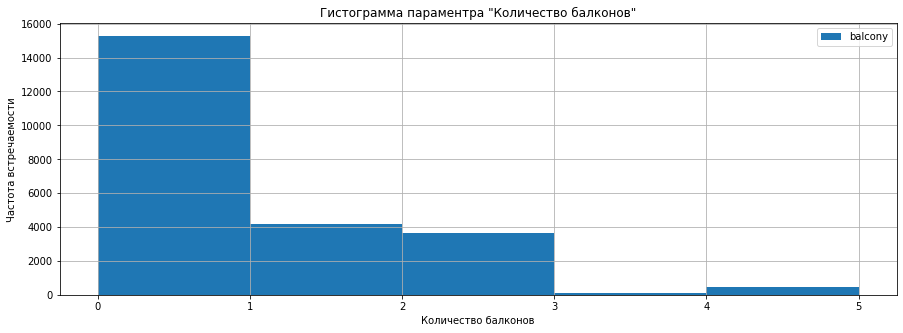

In [596]:
hist_bal_2 = data.plot(y='balcony', kind='hist', bins=5, title = 'Гистограмма параментра "Количество балконов"', grid=True, figsize=(15, 5))
hist_bal_2.set_xlabel('Количество балконов')
hist_bal_2.set_ylabel('Частота встречаемости')

Такой заменой мы сильно исказили изначальное распределение. Квартир с отсутствием балкона оказалось вдвое больше чем квартир с балконом. Это не слишком похоже на правду. Во всех квартирах в которых бывал я - был балкон. Посмотрим как обстоят дела с этим на Яндекс.Недвижимости.

Из почти 40 тыс. объявлений - только 15 тыс. имеют балкон. Удивительно. Оказывается реальная ситуация похожа на то, что получилось у нас. Теперь к такой замене пропусков доверия больше=)

Для красоты поменяем тип данных на int:

In [597]:
data['balcony'] = data['balcony'].astype(int)

#### 7. Столбец 'locality_name' предобработка

Посмотрим на количество пропущеных значений:

In [598]:
data['locality_name'].isna().sum()

49

Посмотрим на данные "глазами":

In [599]:
data.loc[data['locality_name'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1097,3,8600000.0,81.70,2016-04-15,3,3.55,5,50.800000,2,False,False,False,8.800000,0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0
2033,6,5398000.0,80.00,2017-05-30,3,2.65,4,42.600000,2,False,False,False,18.600000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0
2603,20,3351765.0,42.70,2015-09-20,1,2.65,24,15.600000,3,False,False,False,10.700000,0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0
2632,2,5130593.0,62.40,2015-10-11,2,2.65,24,33.100000,21,False,False,False,8.200000,0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
3574,10,4200000.0,46.50,2016-05-28,2,2.65,5,30.800000,5,False,False,False,6.500000,0,NaN,27419.0,8127.0,0.0,NaN,1.0,603.0,45.0
4151,17,17600000.0,89.50,2014-12-09,2,3.00,8,39.620000,7,False,False,False,13.380000,0,NaN,25054.0,3902.0,1.0,485.0,3.0,722.0,869.0
4189,7,9200000.0,80.00,2015-12-10,3,4.00,4,52.300000,3,False,False,False,10.400000,0,NaN,21774.0,3039.0,1.0,690.0,1.0,953.0,223.0
4670,1,5500000.0,83.00,2015-08-14,3,2.65,7,44.864865,6,False,False,False,13.539967,0,NaN,26534.0,5382.0,1.0,446.0,1.0,376.0,350.0
5343,19,13540000.0,85.50,2016-01-20,3,2.65,7,59.100000,5,False,False,False,8.300000,4,NaN,10556.0,9538.0,1.0,67.0,0.0,NaN,303.0
5707,7,3700000.0,30.00,2016-04-29,1,2.65,24,20.000000,23,False,False,False,4.893964,0,NaN,21460.0,16788.0,0.0,NaN,1.0,170.0,49.0


 При первом взгляде в глаза бросается расстояние до ближайшего аэропорта - более 20км для большинства данных. Возникает предположение, что квартиры могут находится не в Санкт-Петербурге. Однако, измерив расстояние от аэропорта до дальней границы города я получил расстояние чуть больше 30км. Это говорит о том, что однозначно сказать, что такие квартиры находятся на пределами СПб нельзя.
 
Можно было бы на основании данных о расстоянии до аэропорта и расстоянии до центра города построить модель, которая бы определила (возможно) конкретный населенный пункт (при соответствующих навыках). Однако, квартир с неизвестной привязкой к местности очень мало и заниматься поисками города нецелесообразно. 

Проще присвоить таким данным категорию "Другое" или "Неизвестно" и двигаться дальше.

In [600]:
data.loc[data['locality_name'].isna(), 'locality_name'] = 'Неизвестно'

Проверяем остаток пустых данных:

In [601]:
data['locality_name'].isna().sum()

0

#### 8. Столбец 'aiports_nearest' и 'cityCenters_nearest' предобработка

Посмотрим на количество пропущеных значений:

In [602]:
data['airports_nearest'].isna().sum()

5542

Смотрим на связь с другими параметрами:

In [603]:
data.corr()['airports_nearest']

total_images          -0.002298
last_price            -0.026239
total_area            -0.030753
rooms                 -0.061199
ceiling_height        -0.072740
floors_total           0.107934
living_area           -0.052548
floor                  0.071597
is_apartment           0.016470
studio                -0.021876
open_plan             -0.013583
kitchen_area           0.007531
balcony                0.048984
airports_nearest       1.000000
cityCenters_nearest    0.272184
parks_around3000       0.000759
parks_nearest         -0.070058
ponds_around3000      -0.049583
ponds_nearest          0.014049
days_exposition       -0.018271
Name: airports_nearest, dtype: float64

Значимой корреляции с каким-либо из параметров не найдено. Продолжаем искать отправную точку для заполнения пропусков.

Посмотрим на распределение значений:

Text(0, 0.5, 'Частота встречаемости')

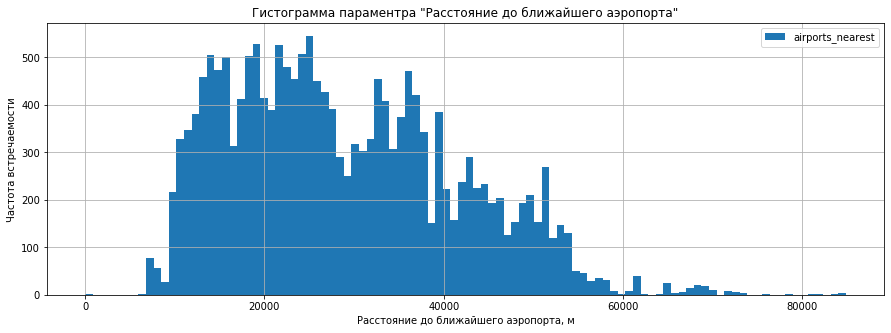

In [604]:
hist_airp_1 = data.loc[~data['airports_nearest'].isna()].plot(y='airports_nearest', kind='hist', bins=100, title = 'Гистограмма параментра "Расстояние до ближайшего аэропорта"', grid=True, figsize=(15, 5))
hist_airp_1.set_xlabel('Расстояние до ближайшего аэропорта, м')
hist_airp_1.set_ylabel('Частота встречаемости')

Данные распределены почти "нормально". Нет заметных выбросов. 

Посмотрим на распределение цены на квартиры с имеющимися данными расстояния до аэропорта и без них:

Text(0, 0.5, 'Частота встречаемости')

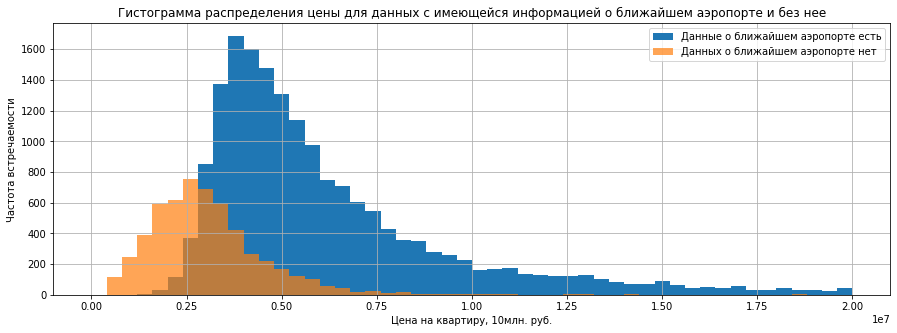

In [605]:
ax = data.loc[~data['airports_nearest'].isna()].plot(kind='hist', y='last_price', range=(0, 2e7), bins=50, label='Данные о ближайшем аэропорте есть', figsize=(15, 5), title='Гистограмма распределения цены для данных с имеющейся информацией о ближайшем аэропорте и без нее')
data.loc[data['airports_nearest'].isna()].plot(kind='hist', y='last_price', range=(0, 2e7), bins=50, alpha=0.7, label='Данных о ближайшем аэропорте нет', ax=ax, grid=True, legend=True) 
ax.set_xlabel('Цена на квартиру, 10млн. руб.')
ax.set_ylabel('Частота встречаемости')


Здесь уже интереснее. Оказывается, что данные без сведений о расстоянии до аэропорта смещены влево относительно обратных данных. Если бы никакой закономерности в пропусках не было, тогда красный график ± повторял бы форму своего старшего брата. 

**Первый вывод:** квартиры с отсутствующими данными расстояния до аэропорта в среднем дешевле. 
Предположение: фактор который оказывает прямое сильное влияние на цену - это расстояние от города. Чем ближе к центру - тем дороже, и наоборот. Об этом же свидетельствует похожее количество пропусков в столбцах cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000. Все эти данные получаются автоматически в зависимости от адреса объекта продажи. Значит, скорее всего алгоритм просто не смог определить геолокацию такого объекта. Но почему?

**Второй вывод:** существует некоторая закономерность пропусков. 

Докажем первый вывод. Посмотрим на цифры:

In [606]:
data.loc[~data['airports_nearest'].isna(), 'last_price'].describe()

count    1.815700e+04
mean     7.558156e+06
std      1.211265e+07
min      1.219000e+04
25%      4.000000e+06
50%      5.250000e+06
75%      7.680000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [607]:
data.loc[data['airports_nearest'].isna(), 'last_price'].describe()

count    5.542000e+03
mean     3.210885e+06
std      3.420516e+06
min      4.300000e+05
25%      2.000000e+06
50%      2.800000e+06
75%      3.700000e+06
max      1.300000e+08
Name: last_price, dtype: float64

Видно, что в данных есть отличия. Посмотрим на уникальные значения населенных пунктов для имеющихся данных 'airports_nearest' и без них:

In [608]:
data.loc[~data['airports_nearest'].isna()]['locality_name'].value_counts()

Санкт-Петербург            15636
посёлок Шушары               436
Пушкин                       369
Колпино                      337
посёлок Парголово            327
Петергоф                     201
Сестрорецк                   183
Красное Село                 176
Ломоносов                    132
Кронштадт                     95
посёлок Металлострой          66
посёлок Стрельна              44
Неизвестно                    41
Павловск                      38
Зеленогорск                   24
посёлок Понтонный             20
посёлок Сапёрный               6
посёлок Молодёжное             5
посёлок Репино                 4
посёлок Песочный               4
посёлок Лисий Нос              2
посёлок Александровская        2
поселок Мурино                 2
посёлок Усть-Ижора             2
посёлок Щеглово                1
посёлок Петро-Славянка         1
поселок Лисий Нос              1
посёлок Левашово               1
посёлок Белоостров             1
Name: locality_name, dtype: int64

In [609]:
data.loc[data['airports_nearest'].isna()]['locality_name'].value_counts()

посёлок Мурино                                             522
Всеволожск                                                 398
Гатчина                                                    307
деревня Кудрово                                            299
Выборг                                                     237
                                                          ... 
посёлок Сумино                                               1
садоводческое некоммерческое товарищество Лесная Поляна      1
деревня Щеглово                                              1
деревня Тихковицы                                            1
деревня Чудской Бор                                          1
Name: locality_name, Length: 345, dtype: int64

Ок. Мы нашли хорошую отправную точку для заполнения пропусков. Есть точные данные, связывающие одни данные с другими. Это название населенного пункта. Усреднив значения у имеющихся данных, мы можем использовать эти значения для заполнения. 

Да, будет некая погрешность. Пусть и высокая погрешость. Но все же меньшая, чем была бы заполни мы пропуски средним по всем имеющимся данным. Тогда, ожидаемо, на гисограмме распределения мы бы увидели один огромный пик в центре, что было бы далеко от реального распределения. А разбив данные по городу - мы уже раскидываем этот пик по сторонам, получая более похожую на правду ситуацию.

Предстоящая задача сложна и требует разбиения себя на маленькие шаги:

**Цель:** написать скрипт, который перебирает все значения в столбце *'airports_nearest'*. Если значение пропущено, тогда он смотрит на соответствующий ему населенный пункт и ищет совпадение с населенным пунктом в списке с имеющимися данными *'airports_nearest'*. Берет оттуда среднее, и заполняет им пропущенное значение.

**Шаги для реализации скрипта:**

1. Написать цикл перебирающий пустые значения *'airporst_nearest'*
2. Для пропущеного значения найти соответствующий населенный пункт (НП)
3. Лемматизация. 1 этап. Вычленить основу этого слова
4. Лемматизация. 2 этап. Вычленить основы слов НП для данных имеющих значения 'airports_nearest'
5. Сравнить основу из этапа 1 со списком из этапа 2.
6. При совпадении - на основе корня слова построить список данных имеющих значения 'airports_nearest'
7. По этому списку найти среднее для airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest,      ponds_around3000 (использовать конструкцию try - except)
8. Заполнить пропуски

Для этого создадим новый датафрейм в который включим столбцы данных получаемых автоматически:

In [610]:
data_for_location = data.iloc[:, 14:]

In [611]:
data_for_location

,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...
23694,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


Приступим к лемматизации!

Основная идея заключается в том, чтобы не искать "глазами" все множество возможных вариантов населенных пунктов. Пусть компьютер сам определит, что имел ввиду пользователь, когда вводил название своего города.

Далее мы сравним, есть ли для объявлений с неизвестными данными о расстояниях - объявления из того же региона, но для которых компьютеру удалось вычислить расстояния. Если такие совпадения найдутся - то мы заполним пропуски опираясь на объявления относящиеся к той же локации.

In [612]:
m = Mystem()

In [613]:
def base_loc(obj): # функция возвращает основу названия населенного пункта
    lemmas = m.lemmatize(obj)
    return lemmas[-2]

Создадим новый столбец, куда сохраним основы слов населенных пунктов:

In [614]:
data_for_location['lemm_location'] = data_for_location['locality_name'].apply(base_loc)

In [615]:
data_for_location.head(5)

,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,lemm_location
0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,санкт-петербург
1,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,шушар
2,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,санкт-петербург
3,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,санкт-петербург
4,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,санкт-петербург


Зафиксируем количество неизвестных в столбце 'data_for_location'

In [616]:
data_for_location['airports_nearest'].isna().sum()

5542

Напишем функции, которые будут вычислять среднее расстояние до аэропорта и центра города

In [617]:
def airport_distance(city_name): # посчитать среднее расстояние до аэропорта для города city_name
    lenght_to_airport = data_for_location.loc[data_for_location['lemm_location'] == city_name, 'airports_nearest'].mean()
    return lenght_to_airport

In [618]:
def city_center_distance(city_name): # посчитать среднее расстояние до центра города для города city_name
    lenght_to_center = data_for_location.loc[data_for_location['lemm_location'] == city_name, 'cityCenters_nearest'].mean()
    return lenght_to_center

Функции написаны. Пора заполнить часть неизвестных данных о расстоянии до аэропорта, основываясь на известных данных для того же города:

In [619]:
# перебираем уникальные имена городов с неизвестными расстояниями до аэропорта
for name in data_for_location.loc[data_for_location['airports_nearest'].isna(), 'lemm_location'].unique(): 
    # если есть уникальный город name в списке городов с известным расстоянием до аэропорта
    if len(data_for_location.loc[(~data_for_location['airports_nearest'].isna()) & (data_for_location['lemm_location'] == name)]) > 0:
        # то заполняем пропуски в столбце 'airports_nearest' на среднее для этого же города но из данных с известным расстоянием
        try:
            data_for_location.loc[(data_for_location['airports_nearest'].isna()) & (data_for_location['lemm_location'] == name), 'airports_nearest'] = airport_distance(name)
        except:
            print('Не удалось заполнить столбец "airports_nearest"')
    

Посмотрим сколько неизвестных осталось:

In [620]:
data_for_location['airports_nearest'].isna().sum()

4810

Практически все заполненные пропуски принадлежат к городу Мурино. Видимо, все при создании объявления допускают ошибку в названии. Орфографическая ошибка для такого количества людей маловероятна. Скорее всего статус населенного пункта изменился с "поселка" на "город". Часть объявлений теперь отражала уже старую, недостоверную информацию. Ну и часть собственников, возможно, по привычке, вводила старое название.

До предобработки - объявлений оттуда было всего 2. Теперь около 600. Город небольшой, поэтому расстояние до аэропорта не будет иметь большой погрешности. 

Ок, нам удалось обработать 10% неизвестных. Немного. Значит, для остальных данных нужен другой способ. 

Пока проделаем тоже самое для центра города.

In [621]:
# перебираем уникальные имена городов с неизвестными расстояниями до центра
for name in data_for_location.loc[data_for_location['cityCenters_nearest'].isna(), 'lemm_location'].unique(): 
    # если есть уникальный город name в списке городов с известным расстоянием до центра
    if len(data_for_location.loc[(~data_for_location['cityCenters_nearest'].isna()) & (data_for_location['lemm_location'] == name)]) > 0:
        # то заполняем пропуски в столбце 'cityCenters_nearest' на среднее для этого же города но из данных с известным расстоянием
        try:
            data_for_location.loc[(data_for_location['cityCenters_nearest'].isna()) & (data_for_location['lemm_location'] == name), 'cityCenters_nearest'] = city_center_distance(name)
        except:
            print('Не удалось заполнить столбец "airports_nearest"')

In [622]:
data_for_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 9 columns):
locality_name          23699 non-null object
airports_nearest       18889 non-null float64
cityCenters_nearest    18889 non-null float64
parks_around3000       18181 non-null float64
parks_nearest          8079 non-null float64
ponds_around3000       18181 non-null float64
ponds_nearest          9110 non-null float64
days_exposition        20518 non-null float64
lemm_location          23699 non-null object
dtypes: float64(7), object(2)
memory usage: 1.6+ MB


Отлично. Осталось разобраться с остальными пропусками

Остальные города легко можно найти на карте. Причина, по которой для них не найдены расстояния до центра и аэропорта неизвестны. Можно было бы восполнить пропуски автоматически, используя алгоритмы и карты местности, но таких навыков у меня нет.

Можно для первых 20 населенных пунктов найти расстояние до аэропорта вручную. Тогда еще 3тыс. объявлений получат средние искомые значения. В учебном проекте нет вопросов касающихся такого расстояния, поэтому и мы так усложнять не станем.

Для дальнейшего анализа пока присвоим значение -1 расстоянию до аэропорта.

In [623]:
data_for_location.loc[data_for_location['airports_nearest'].isna(), 'airports_nearest'] = -1

In [624]:
data_for_location['airports_nearest'].isna().sum()

0

Интересно, что здесь для всех данных, видимо, центром выступает Санкт-Петербург. И цена, соответственно будет зависеть не от центра какого-то конкретного города, а от удаленности жилья от центра Санкт-Петербурга.

Попробуем найти расстояние до центра опираясь на цену. 

**Проверим гипотезу:** Чем дальше недвижимость от Санкт-Петербурга, тем она дешевле.

Для этого создадим столбец где **посчитаем цену квадратного метра** для каждой квартиры: <a id='sq_meter_price'></a>

In [625]:
data['sq_meter_price'] = data['last_price'] / data['total_area']

Построим сводную таблицу куда внесем населенный пункт, цену, и расстояние до центра.

In [626]:
locality_pivot = data.pivot_table(index='locality_name', 
                                  values=['sq_meter_price', 'cityCenters_nearest']).sort_values(by='sq_meter_price', ascending=False)

In [627]:
locality_pivot.corr()

,cityCenters_nearest,sq_meter_price
cityCenters_nearest,1.000000,-0.139578
sq_meter_price,-0.139578,1.000000


Как мы видим, корреляции практически нет. То есть, если данные в графе 'cityCenters_nearest' являются расстоянием до центра Петербурга, тогда связи их с ценой на квадратный метр не наблюдается. Соответственно гипотеза не подтвердилась.

**Вывод:** Цена за квадратный метр за пределами Санкт-Петербурга примерно одинакова. Это утверждение не распространяется на глухие маленькие деревни.

В таком случае будет целесообразно заполнить пропущенные данные о расстоянии до центра средним для квартир находящихся за пределами Петербурга.

In [628]:
data_for_location.loc[data_for_location['cityCenters_nearest'].isna(), 'cityCenters_nearest'] = data_for_location.loc[~data_for_location['cityCenters_nearest'].isna(), 'cityCenters_nearest'].mean()

In [629]:
data_for_location['cityCenters_nearest'].isna().sum()

0

Со столбцами 'cityCenters_nearest' и 'airports_nearest' разобрались. Обновим аналогичные столбцы в главном датафрейме:

In [630]:
data['cityCenters_nearest'] = data_for_location['cityCenters_nearest']
data['airports_nearest'] = data_for_location['airports_nearest']

Переведем наши столбцы 'cityCenters_nearest' и 'airports_nearest' в int64. Зачем нам лишние нули после запятой?

In [631]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype(int)

In [632]:
data['airports_nearest'] = data['airports_nearest'].astype(int)

In [633]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23699 non-null object
airports_nearest        23699 non-null int64
cityCenters_nearest     23699 non-null int64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around3000

#### 9. Столбец ['parks_around3000', parks_nearest, 'ponds_around3000', ponds_nearest] предобработка

Данные иэ этих столбцов тоже получены автоматически. Посмотрим на них:

In [634]:
data.loc[~data['parks_around3000'].isna(), 'parks_around3000'].value_counts()

0.0    10106
1.0     5681
2.0     1747
3.0      647
Name: parks_around3000, dtype: int64

Большая часть квартир не имеет в радиусе 3км хотя бы одного парка.

Посмотрим на известные значения parks_nearest тех собственников, чьи квартиры не имеют парка, и указали это в объявлении:

In [635]:
data.loc[(~data['parks_nearest'].isna()) & (data['parks_around3000'] == 0)][['parks_around3000', 'parks_nearest']]

,parks_around3000,parks_nearest
1590,0.0,3064.0
10959,0.0,3190.0
19208,0.0,3013.0
19430,0.0,3190.0


Всего 4 объявления - мало, чтобы что-то утверждать. Но очень небольшое отклонение от среднего позволяет предположить, что и для остальных квартир будет справедливым заполнить пропуски в parks_nearest расстоянием немного превышающим 3км. Например, 3100:

In [636]:
data.loc[data['parks_nearest'].isna(), 'parks_nearest'] = 3100

In [637]:
data['parks_nearest'].isna().sum()

0

Тогда пропущеные значения в 'parks_around3000' заполним нулями:

In [638]:
data.loc[data['parks_around3000'].isna(), 'parks_around3000'] = 0

In [639]:
data['parks_around3000'].isna().sum()

0

In [640]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23699 non-null object
airports_nearest        23699 non-null int64
cityCenters_nearest     23699 non-null int64
parks_around3000        23699 non-null float64
parks_nearest           23699 non-null float64
ponds_around300

Переведем оба столбца в int64:

In [641]:
data['parks_around3000'] = data['parks_around3000'].astype(int)

In [642]:
data['parks_nearest'] = data['parks_nearest'].astype(int)

In [643]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23699 non-null object
airports_nearest        23699 non-null int64
cityCenters_nearest     23699 non-null int64
parks_around3000        23699 non-null int64
parks_nearest           23699 non-null int64
ponds_around3000   

Перейдем к водоемам. Данные имеют тот же порядок, что и данные о парках, что подсказывает обратиться к методам обработки из прошлого шага:

Заполним нулями отсутствующую информацию в 'ponds_around3000' а в 'ponds_nearest' впишем 3100

In [644]:
data.loc[data['ponds_around3000'].isna(), 'ponds_around3000'] = 0

In [645]:
data['ponds_around3000'].isna().sum()

0

In [646]:
data.loc[data['ponds_nearest'].isna(), 'ponds_nearest'] = 3100

In [647]:
data['ponds_nearest'].isna().sum()

0

Переведем оба столбца в int64:

In [648]:
data['ponds_around3000'] = data['ponds_around3000'].astype(int)

In [649]:
data['ponds_nearest'] = data['ponds_nearest'].astype(int)

In [650]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23699 non-null object
airports_nearest        23699 non-null int64
cityCenters_nearest     23699 non-null int64
parks_around3000        23699 non-null int64
parks_nearest           23699 non-null int64
ponds_around3000   

**Вывод:** у более чем половины объявлений отсутствовала информация о расстоянии до ближашего парка. Я думаю, что причина здесь кроется в обработке данных комьютером. Как мы выяснили выше, для большинства объявлений компьютер не смог установить геолокацию объекта. Отчего не посчитал все необходимые расстояния до объектов инфраструктуры. Чтобы впредь данные на выходе были "чище" стоит залезть под капот алгоритмов обрабатывающих информацию о местоположении недвижимости.

#### 10. Столбец 'days_exposition' предобработка

Посмотрим на него. Сколько всего пропущеных значений и какая есть связь с другими переменными:

In [651]:
data['days_exposition'].isna().sum()

3181

In [652]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [653]:
data[data['days_exposition'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.000000,0,Санкт-Петербург,18863,16028,1,482,2,755,NaN,120370.370370
7,5,7915000.0,71.6,2019-04-18,2,2.65,24,38.702703,22,False,False,False,18.900000,2,Санкт-Петербург,23982,11634,0,3100,0,3100,NaN,110544.692737
44,13,5350000.0,40.0,2018-11-18,1,2.65,22,21.621622,3,False,False,False,6.525285,1,Санкт-Петербург,30471,11603,1,620,1,1152,NaN,133750.000000
45,17,5200000.0,50.6,2018-12-02,2,2.65,9,30.300000,7,False,False,False,7.000000,0,Санкт-Петербург,30011,12872,0,3100,0,3100,NaN,102766.798419
46,17,6600000.0,52.1,2019-01-31,2,2.60,24,29.700000,9,False,False,False,8.300000,2,Санкт-Петербург,15114,12702,0,3100,0,3100,NaN,126679.462572


Пока ничего особенного не видно.

In [654]:
data.corr().tail()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price
parks_nearest,-0.041064,-0.165833,-0.170788,-0.141517,-0.181246,0.130500,-0.177247,0.088437,-0.007029,0.033673,0.020283,-0.112911,0.053368,-0.217896,0.188447,-0.880478,1.000000,-0.339893,0.312651,-0.040943,-0.275789
ponds_around3000,0.011323,0.208621,0.200294,0.121276,0.190875,-0.048682,0.183702,-0.029710,0.024400,-0.009690,-0.004127,0.176492,-0.038339,0.180358,-0.092271,0.392668,-0.339893,1.000000,-0.862849,0.066289,0.304363
ponds_nearest,-0.013846,-0.171049,-0.165626,-0.102038,-0.151894,-0.001494,-0.150340,-0.004256,-0.019837,0.007031,0.002570,-0.146112,0.034066,-0.189527,0.086518,-0.330548,0.312651,-0.862849,1.000000,-0.055359,-0.275585
days_exposition,-0.026657,0.081146,0.149675,0.126961,0.096314,-0.052126,0.145112,-0.039463,0.015262,-0.022476,-0.024112,0.114665,-0.027834,-0.014767,-0.058688,0.055867,-0.040943,0.066289,-0.055359,1.000000,0.048120
sq_meter_price,0.132780,0.736499,0.301960,0.055420,0.267358,0.147927,0.232045,0.129068,0.044725,0.015636,0.008266,0.381522,0.023376,0.252749,-0.290445,0.291687,-0.275789,0.304363,-0.275585,0.048120,1.000000


Никакой значимой взаимосвязи с другими переменными не наблюдается.

**Проверим гипотезу:** чем ниже стоимость квадратного метра, тем быстрее продается квартира:

Для этого, удобнее будет разбить срок продажи квартиры на категории. Например, "Быстро", "Средне", "Долго".

Посмотрим на распределение значений:

In [655]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Примем за границы категорий 1 и 3 квартили. Соответсвтенно "Средне" будет лежать между 25% и 75%:

Напишем функцию, которая присвоит категорию каждому объявлению:

In [656]:
def to_category(obj):
    if obj < 45:
        return 'Быстро'
    elif obj > 232:
        return 'Медленно'
    else:
        return 'Средне'

Создадим новый столбец для нашей категории:

In [657]:
data_sale = data[['days_exposition', 'sq_meter_price']]

In [658]:
data_sale['sale_cat'] = data_sale.loc[~data['days_exposition'].isna(), 'days_exposition'].apply(to_category)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [659]:
data_sale.head()

,days_exposition,sq_meter_price,sale_cat
0,NaN,120370.370370,NaN
1,81.0,82920.792079,Средне
2,558.0,92785.714286,Медленно
3,424.0,408176.100629,Медленно
4,121.0,100000.000000,Средне


Создадим сводную таблицу, куда включим цену квадратного метра и категорию скорости продажи. 

Чтобы избежать влияния хвостов распределения, рассмотрим как на скорость продажи влияет цена квадратного метра в диапазоне 1 - 3 квартилей (76 тыс. руб. - 115 тыс. руб.):

In [660]:
sale_time_pivot = data_sale.query('76000 < sq_meter_price < 115000').pivot_table(index='sale_cat', 
                                  values=['sq_meter_price']).sort_values(by='sq_meter_price', ascending=False)

In [661]:
sale_time_pivot

,sq_meter_price
sale_cat,
Быстро,95385.194081
Средне,94820.752829
Медленно,94194.821144


**Вывод: гипотеза не подтвердилась.** Мы наблюдаем обратное. В среднем квартиры продавались быстрее те, что стоили дороже. 
    
Понимаю, что такой вывод мог получиться в результате неверно взятой выборки. Поэтому и такой результат я нигде впоследствии использовать не буду.

Так как данные столбца 'days_exposition' тоже получены автоматически. Эти есть данные ничто иное как разница между датой публикации объявления и датой снятия с публикации. Так как для всех данных дата публикации есть, значит, причина пропусков в том, что для некоторых объявлений просто нет даты снятия с публикации. Почему компьютер и не смог вычислить разницу. Вывод - возможно, объявления все еще опубликованы.

Таких объявлений достаточно много - более 10%. Просто отбросить их - значит потерять десятую часть данных. При этом использовать их тоже нужно с осторожностью - ведь окончательная цена, например, еще не устоялась и может корректироваться со временем. Пока заполним пропуски медианным значением.

In [662]:
data.loc[data['days_exposition'].isna(), 'days_exposition'] = data.loc[~data['days_exposition'].isna(), 'days_exposition'].median()

In [663]:
data['days_exposition'].isna().sum()

0

Смотрим на итоговую таблицу:

In [664]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23699 non-null object
airports_nearest        23699 non-null int64
cityCenters_nearest     23699 non-null int64
parks_around3000        23699 non-null int64
parks_nearest           23699 non-null int64
ponds_around3000   

Приведем столбцы **['last_price', 'days_exposition', 'sq_meter_price']** к типу int64 и закончим на этом предобработку данных:

In [665]:
data['last_price'] = data['last_price'].astype(int)
data['days_exposition'] = data['days_exposition'].astype(int)
data['sq_meter_price'] = data['sq_meter_price'].astype(int)

In [666]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23699 non-null int64
last_price              23699 non-null int64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23699 non-null object
airports_nearest        23699 non-null int64
cityCenters_nearest     23699 non-null int64
parks_around3000        23699 non-null int64
parks_nearest           23699 non-null int64
ponds_around3000     

**Вывод по Шагу 2**: Все пропуски обрабатаны. Причины каких-то из них лежли на поверхности, а какие-то установить точно так и не удалось. В любом случае, я постарался заполнить пропуски так, чтобы данные в итоге оказались максимально полными, но при этом, чтобы мое вмешательство не исказило результаты исследования.  

### Шаг 3. Добавление в таблицу <a id='step_3'></a>

Определим цели этапе этого шага:

1. Посчитать и добавить в таблицу цену квадратного метра
2. Посчитать и добавить в таблицу день недели, месяц и год публикации объявления
3. Посчитать и добавить в таблицу этаж квартиры; варианты — первый, последний, другой
4. Посчитать и добавить в таблицу соотношение жилой и общей площади, а также отношение площади кухни к общей

#### 1. Посчитать и добавить в таблицу цену квадратного метра

Цену квадратного метра я вынужден был [посчитать и добавить в таблицу ранее](#sq_meter_price), для анализа пропущеных значений. Поэтому этот пункт с уверенностью пропускаем!

#### 2. Посчитать и добавить в таблицу день недели, месяц и год публикации объявления:


Для нахождения дня недели воспользуемся встроенной в pandas функцией weekday. Для удобства, прибавим к полученным значениям 1:

In [667]:
data['weekday'] = data['first_day_exposition'].dt.weekday + 1

In [668]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,weekday
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.00000,0,Санкт-Петербург,18863,16028,1,482,2,755,95,120370,4
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.00000,2,посёлок Шушары,12817,18603,0,3100,0,3100,81,82920,2
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,False,False,False,8.30000,0,Санкт-Петербург,21741,13933,1,90,2,574,558,92785,4
3,0,64900000,159.0,2015-07-24,3,2.65,14,85.945946,9,False,False,False,25.93801,0,Санкт-Петербург,28098,6800,2,84,3,234,424,408176,5
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.00000,0,Санкт-Петербург,31856,8098,2,112,1,48,121,100000,2


Для нахождения дня недели воспользуемся встроенной в pandas функцией month:

In [669]:
data['month'] = data['first_day_exposition'].dt.month

In [670]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,weekday,month
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.00000,0,Санкт-Петербург,18863,16028,1,482,2,755,95,120370,4,3
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.00000,2,посёлок Шушары,12817,18603,0,3100,0,3100,81,82920,2,12
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,False,False,False,8.30000,0,Санкт-Петербург,21741,13933,1,90,2,574,558,92785,4,8
3,0,64900000,159.0,2015-07-24,3,2.65,14,85.945946,9,False,False,False,25.93801,0,Санкт-Петербург,28098,6800,2,84,3,234,424,408176,5,7
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.00000,0,Санкт-Петербург,31856,8098,2,112,1,48,121,100000,2,6


Аналогичная процедура для нахождения года:

In [671]:
data['year'] = data['first_day_exposition'].dt.year

In [672]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,weekday,month,year
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.00000,0,Санкт-Петербург,18863,16028,1,482,2,755,95,120370,4,3,2019
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.00000,2,посёлок Шушары,12817,18603,0,3100,0,3100,81,82920,2,12,2018
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,False,False,False,8.30000,0,Санкт-Петербург,21741,13933,1,90,2,574,558,92785,4,8,2015
3,0,64900000,159.0,2015-07-24,3,2.65,14,85.945946,9,False,False,False,25.93801,0,Санкт-Петербург,28098,6800,2,84,3,234,424,408176,5,7,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.00000,0,Санкт-Петербург,31856,8098,2,112,1,48,121,100000,2,6,2018


#### 3. Посчитать и добавить в таблицу этаж квартиры; варианты — первый, последний, другой

Для этого нам нужно написать простую категоризирующую функцию:

In [673]:
def floor_cat(row):
    if row['floors_total'] == row['floor']:
        return 'Последний'
    elif row['floor'] == 1:
        return 'Первый'
    else:
        return 'Другой'

Создаем новый столбец, где будем хранить сведения о категории. Применяем написанную выше функцию:

In [674]:
data['floor_cat'] = data.apply(floor_cat, axis=1)

In [675]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,weekday,month,year,floor_cat
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.00000,0,Санкт-Петербург,18863,16028,1,482,2,755,95,120370,4,3,2019,Другой
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.00000,2,посёлок Шушары,12817,18603,0,3100,0,3100,81,82920,2,12,2018,Первый
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,False,False,False,8.30000,0,Санкт-Петербург,21741,13933,1,90,2,574,558,92785,4,8,2015,Другой
3,0,64900000,159.0,2015-07-24,3,2.65,14,85.945946,9,False,False,False,25.93801,0,Санкт-Петербург,28098,6800,2,84,3,234,424,408176,5,7,2015,Другой
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.00000,0,Санкт-Петербург,31856,8098,2,112,1,48,121,100000,2,6,2018,Другой


#### 4. Посчитать и добавить в таблицу соотношение жилой и общей площади, а также отношение площади кухни к общей

Оба этих параметра я уже вычислял выше. Сделаем это еще раз и теперь добавим в итоговую таблицу:

In [676]:
data['liv_total_ratio'] = data['living_area'] /  data['total_area']

In [677]:
data['kit_total_ratio'] = data['kitchen_area'] /  data['total_area']

In [678]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,weekday,month,year,floor_cat,liv_total_ratio,kit_total_ratio
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.00000,0,Санкт-Петербург,18863,16028,1,482,2,755,95,120370,4,3,2019,Другой,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.00000,2,посёлок Шушары,12817,18603,0,3100,0,3100,81,82920,2,12,2018,Первый,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,False,False,False,8.30000,0,Санкт-Петербург,21741,13933,1,90,2,574,558,92785,4,8,2015,Другой,0.612500,0.148214
3,0,64900000,159.0,2015-07-24,3,2.65,14,85.945946,9,False,False,False,25.93801,0,Санкт-Петербург,28098,6800,2,84,3,234,424,408176,5,7,2015,Другой,0.540541,0.163132
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.00000,0,Санкт-Петербург,31856,8098,2,112,1,48,121,100000,2,6,2018,Другой,0.320000,0.410000


**Вывод по Шагу 3:** Все намеченные цели выполнены. Переходим к аналицу данных!

### Шаг 4.  Исследовательский анализ данных: <a id='step_4'></a>

Опишем цели этого шага:

1. [Изучить следующие параметры: площадь, цена, число комнат, высота потолков](#step_4_task_1)
2. [Построить гистограммы](#step_4_task_2) для каждого параметра
3. [Выполнить задание_1](#step_4_task_3): "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
4. [Выполнить задание_2](#step_4_task_4): "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
5. [Выполнить задание_3](#step_4_task_5): "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*.
6. [Выполнить задание_4](#step_4_task_6): "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.
7. [Выполнить задание_5](#step_4_task_7): "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"

#### 1. Изучить следующие параметры: площадь, цена, число комнат, высота потолков <a id='step_4_task_1'></a>

Изучим параметр **площадь**:

In [679]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

Среднее значение площади по всем данным - 60,34м2. Медиана - 52м2.

Изучим параметр **цена**:

In [680]:
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Среднее значение цены по всем данным - 6,54 млн. руб. Медиана - 4,65 млн. руб.

Изучим параметр **количество комнат**:

In [681]:
data['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Среднее значение и медиана почти сходятся. Что говорит нам о том, что выюросов, влияющих на среднее практически нет.

Изучим параметр **высота потолков**:

In [682]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.698721
std          0.253208
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

Среднее значение и медиана очень близки благодаря обработанным [выше](#seiling_hight) пропускам и выбросам.

**Вывод**: в изученных данных не наблюдается заметных выбросов. Данные подготовлены для дальнейшего анализа.

#### 2. Построить гистограммы для каждого параметра <a id='step_4_task_2'></a>

Гистограмма распределения **'total_area'**:

Text(0, 0.5, 'Частота встречаемости')

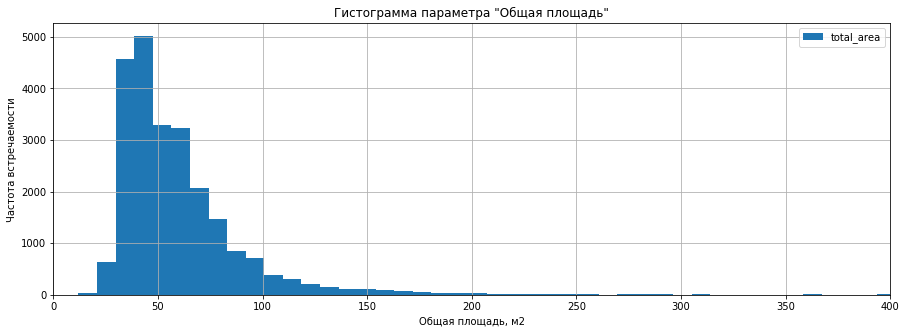

In [683]:
hist_totar = data.plot(y='total_area', kind='hist', xlim=(0, 400), bins=100, title = 'Гистограмма параметра "Общая площадь"', grid=True, figsize=(15, 5))
hist_totar.set_xlabel('Общая площадь, м2')
hist_totar.set_ylabel('Частота встречаемости')

График распределения стремиться к нормальному. Мы видим правую ассиметрию, что говорит о большом разбросе значений в правой стороне графика.

Гистограмма распределения **'last_price'**:

Text(0, 0.5, 'Частота встречаемости')

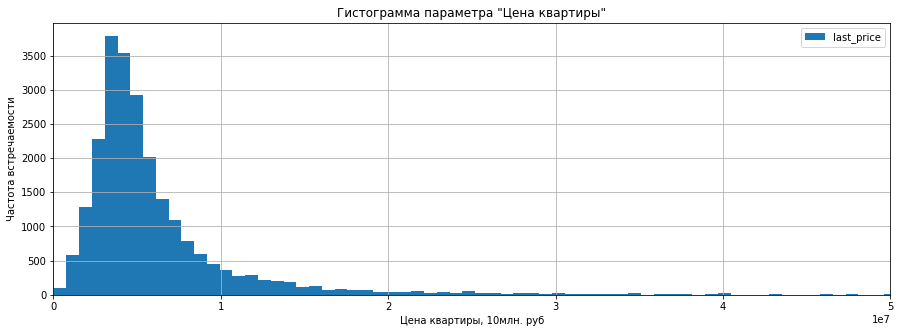

In [684]:
hist_lp = data.plot(y='last_price', kind='hist', xlim=(0, 5e7), bins=1000, title = 'Гистограмма параметра "Цена квартиры"', grid=True, figsize=(15, 5))
hist_lp.set_xlabel('Цена квартиры, 10млн. руб')
hist_lp.set_ylabel('Частота встречаемости')

График распределения стремиться к нормальному. Остальные выводы аналогичны предыдущим.

Гистограмма распределения **'rooms'**:

Text(0, 0.5, 'Частота встречаемости')

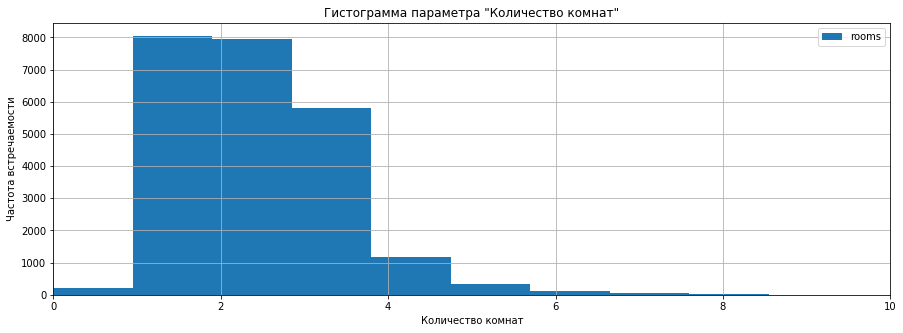

In [685]:
hist_rooms = data.plot(y='rooms', kind='hist', bins=20, xlim=(0, 10), title = 'Гистограмма параметра "Количество комнат"', grid=True, figsize=(15, 5))
hist_rooms.set_xlabel('Количество комнат')
hist_rooms.set_ylabel('Частота встречаемости')

Здесь мы тоже наблюдаем распределение стремящееся к нормальному. На графике видно, что количество 1-комнатных и 2-комнатных квартир практически равно. Квартир имеющих больше 3-комнат и меньше 1 комнаты (студии) сильно меньше. 8-комнатные и больше - практически не встречаются.

Гистограмма распределения **'ceiling_hight'**:

Text(0, 0.5, 'Частота встречаемости')

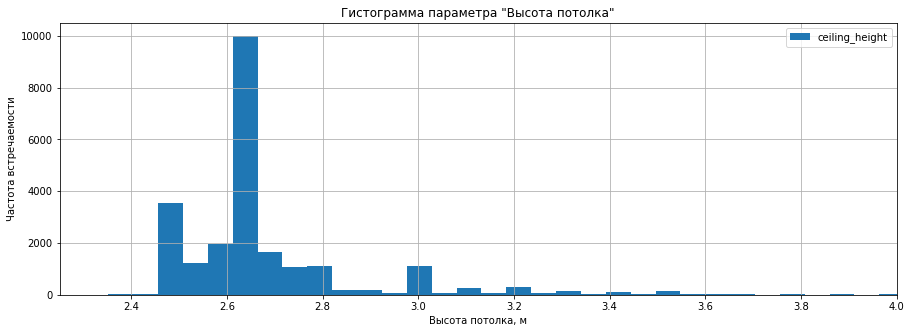

In [686]:
hist_ch = data.plot(y='ceiling_height', kind='hist', bins=250, xlim=(2.25, 4), title = 'Гистограмма параметра "Высота потолка"', grid=True, figsize=(15, 5))
hist_ch.set_xlabel('Высота потолка, м')
hist_ch.set_ylabel('Частота встречаемости')

Из-за произведенных [ранее](#seiling_hight) преобразований - количество квартир с высотой потолка 2,65м - составляет почти половину от общего количества. Что вполне справедливо. Так же, чуть больше 20% квартир имеют высоту всего 2,5м. В целом, более 90% всех квартир имеют выстоту потолка от 2,5м до 3м.

#### 3. Задание_1 <a id='step_4_task_3'></a>

**Цель:** "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"

Изучим **'days_exposition'**:

In [687]:
data['days_exposition'].describe()

count    23699.000000
mean       169.360226
std        206.535633
min          1.000000
25%         45.000000
50%         95.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

Первое, что бросается в глаза - это высокое значение стандартного отклонения. Это говорит, что разброс значений "справа" очень велик. И значения распределены на промежутке примерно 0 - 400. О большом разбросе говорит и разница почти в 2 раза между медианой и средним. Значит, обычно, время продажи квартиры варьируется от нескольких дней до более года. 

Построим гистограмму распределения:

Text(0, 0.5, 'Частота встречаемости')

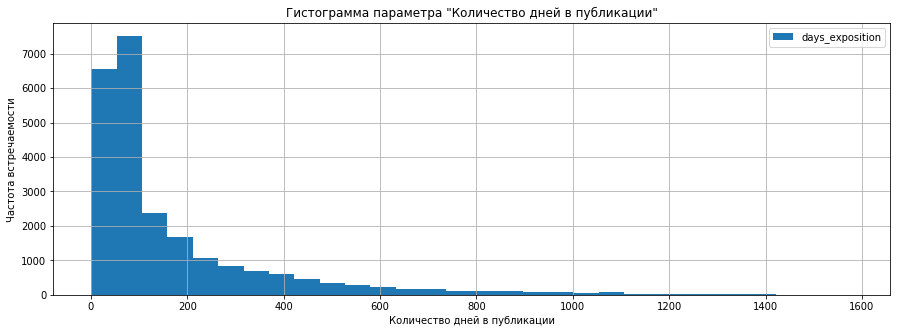

In [688]:
hist_de = data.plot(y='days_exposition', kind='hist', bins=30, title = 'Гистограмма параметра "Количество дней в публикации"', grid=True, figsize=(15, 5))
hist_de.set_xlabel('Количество дней в публикации')
hist_de.set_ylabel('Частота встречаемости')

Text(0, 0.5, 'Дней в публикации')

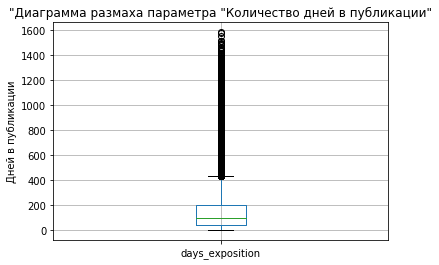

In [689]:
de_bxp_1 = data.boxplot('days_exposition')
de_bxp_1.set_title('"Диаграмма размаха параметра "Количество дней в публикации"')
de_bxp_1.set_ylabel('Дней в публикации')

**Вывод**: Половина всех значений лежит между 1 и 3 квартилями (22 и 199 дней соответственно). Значит, можно утверждать, что продажа квартиры занявшая **менее 45 дней - достаточно быстрая**, а **более 199 - необычно долгая**.

#### 4. Задание_2: <a id='step_4_task_4'></a>

**Цель**: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."

Посмотрим на описание всего датафрейма целиком:

In [690]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,weekday,month,year,liv_total_ratio,kit_total_ratio
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.698721,10.671379,34.439309,5.892358,10.440956,0.591080,23540.992025,14469.580615,0.469049,2210.524073,0.590911,2107.460484,169.360226,9.942121e+04,3.569307,6.400101,2017.367146,0.562820,0.185026
std,5.682529,1.088701e+07,35.654083,1.078405,0.253208,6.585316,22.226257,4.885249,5.995644,0.959298,16642.277592,7681.675025,0.748534,1252.859795,0.883999,1267.806964,206.535633,5.030681e+04,1.789082,3.491561,1.039771,0.101263,0.069739
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,-1.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,1.110000e+02,1.000000,1.000000,2014.000000,0.021583,0.025381
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,7.000000,0.000000,11990.500000,10927.000000,0.000000,601.000000,0.000000,637.000000,45.000000,7.658500e+04,2.000000,3.000000,2017.000000,0.500000,0.136859
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,23196.000000,14469.000000,0.000000,3100.000000,0.000000,3100.000000,95.000000,9.500000e+04,4.000000,6.000000,2017.000000,0.557080,0.163132
75%,14.000000,6.800000e+06,69.900000,3.000000,2.700000,16.000000,42.000000,8.000000,11.976949,1.000000,35818.500000,15752.500000,1.000000,3100.000000,1.000000,3100.000000,199.000000,1.142560e+05,5.000000,10.000000,2018.000000,0.631579,0.223717
max,50.000000,7.630000e+08,900.000000,19.000000,14.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,3100.000000,1580.000000,1.907500e+06,7.000000,12.000000,2019.000000,1.000000,0.787879


Что удалось обнаружить:

1. Низкий минимум и высокий максимум у 'last_price'
2. То же самое справедливо и для 'total_area'
3. 0 в качестве минимума у 'rooms' и 19 как максимум
4. 1м высота потолка минимум и 14 максимум
5. Дом в 60 этажей - необычно много, зная что максимальная жилая высотка на территори ЛО всего 37 этажей.
6. Минимальная жилая площадь - 2м2. Слишком мало.
7. Минимальная площадь кухни - 1,3м2. Слишком мало.
8. Максимальное количество дней в публикации - 1580. Слишком много. 
9. Минимальная и максимальная цена квадратного метра.

Начнем собирать **final_data**, где мы исключим влияние редких и выбивающихся значений:

Для старта определим - что есть редкие и выбивающиеся значения?

**Редкими** - будем считать значения сильно отличающиеся от основной массы, и при этом, их доля в теле общей массы значений очень мала (менее 1%). 

**Выбивающимися** - будем считать значения лежащие за пределами "усов" boxplot. Значения не попадающие в 1,5 межквартильных размаха.

1. Посмотрим на объявления, цена которых составила менее 1 млн. руб.:

In [691]:
data.query('last_price < 1e6').sort_values(by='last_price').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,weekday,month,year,floor_cat,liv_total_ratio,kit_total_ratio
8793,7,12190,109.0,2019-03-20,2,2.75,25,32.000000,25,False,False,False,40.500000,0,Санкт-Петербург,36421,9176,1,805,0,3100,8,111,3,3,2019,Последний,0.293578,0.371560
14911,5,430000,54.0,2018-06-26,2,2.65,3,29.189189,3,False,False,False,8.809135,0,посёлок станции Свирь,-1,14469,0,3100,0,3100,44,7962,2,6,2018,Последний,0.540541,0.163132
17456,7,430000,30.4,2019-04-22,1,2.65,2,16.000000,1,False,False,False,6.000000,0,Сланцы,-1,14469,0,3100,0,3100,95,14144,1,4,2019,Первый,0.526316,0.197368
16274,18,440000,40.0,2018-07-10,1,2.65,5,21.621622,1,False,False,False,6.525285,0,деревня Старополье,-1,14469,0,3100,0,3100,45,11000,2,7,2018,Первый,0.540541,0.163132
9581,7,450000,43.4,2018-08-31,2,2.65,5,30.300000,3,False,False,False,5.500000,0,деревня Старополье,-1,14469,0,3100,0,3100,96,10368,5,8,2018,Другой,0.698157,0.126728


Всего 1 сильно выбивающееся значение. Скорее всего мы имеем дело с опечаткой. Исправим цену домножив ее на 1000

In [692]:
data.loc[8793, 'last_price'] = data.loc[8793, 'last_price'] * 1000

In [693]:
data.loc[8793, 'last_price']

12190000

Теперь изучим максимум. Посмотрим как много значений выбиваются из верхнего "уса" boxplot:

Text(0, 0.5, 'Цена квартиры, 10млн. руб')

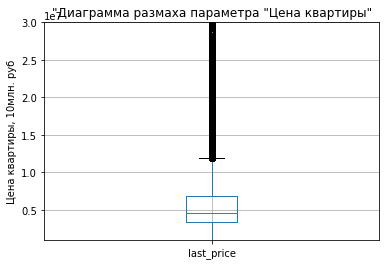

In [694]:
lp_bxp_1 = data.boxplot('last_price')
plt.ylim(1e6, 3e7)
lp_bxp_1.set_title('"Диаграмма размаха параметра "Цена квартиры"')
lp_bxp_1.set_ylabel('Цена квартиры, 10млн. руб')

Верхняя граница "уса" 11.9 млн. руб. Все что выше будем считать выбивающимися значениями.

In [695]:
data.query('last_price > 11.9e6').sort_values(by='last_price')['last_price'].count()

2035

Почти 10% оъявлений не попадут в итоговую таблицу. Начнем собирать итоговую таблицу для анализа **final_data**:

In [696]:
final_data = data.query('last_price < 11.9e6')

In [697]:
final_data.shape

(21637, 29)

2. Обратимся к 'total_area'. Посмотрим на его минимум:

In [698]:
data.sort_values(by='total_area').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,weekday,month,year,floor_cat,liv_total_ratio,kit_total_ratio
19904,4,2400000,12.0,2017-07-19,1,2.55,5,10.000000,2,False,False,False,1.957586,0,Санкт-Петербург,21314,964,1,886,2,45,200,200000,3,7,2017,Другой,0.833333,0.163132
17961,3,1400000,13.0,2017-12-03,1,2.60,9,7.027027,1,False,False,False,2.120718,0,Санкт-Петербург,14350,15945,0,3100,1,185,410,107692,7,12,2017,Первый,0.540541,0.163132
19546,3,1850000,13.0,2019-03-11,1,3.40,5,7.027027,2,False,False,False,2.120718,0,Санкт-Петербург,24915,5483,1,644,0,3100,24,142307,1,3,2019,Другой,0.540541,0.163132
19807,0,3800000,13.0,2018-07-04,1,2.65,5,10.000000,3,False,False,False,2.120718,0,Санкт-Петербург,21302,1242,1,592,3,27,9,292307,3,7,2018,Другой,0.769231,0.163132
19558,2,1686000,13.2,2018-12-17,1,2.65,5,7.135135,1,False,False,False,2.153344,0,Санкт-Петербург,19891,4165,1,361,1,155,19,127727,1,12,2018,Первый,0.540541,0.163132
19642,5,1190000,14.0,2018-07-29,1,2.65,5,11.000000,1,False,False,False,2.000000,0,Санкт-Петербург,9898,11122,0,3100,0,3100,4,85000,7,7,2018,Первый,0.785714,0.142857
16949,9,1550000,15.0,2018-08-21,1,2.70,9,8.108108,1,False,False,False,2.446982,0,Санкт-Петербург,51048,16376,0,3100,1,1079,42,103333,2,8,2018,Первый,0.540541,0.163132
12040,5,1900000,15.0,2018-06-27,1,2.50,5,8.108108,1,False,False,False,2.446982,0,Сосновый Бор,-1,14469,0,3100,0,3100,45,126666,3,6,2018,Первый,0.540541,0.163132
8886,10,2450000,15.5,2018-08-22,0,2.65,5,10.000000,2,False,True,False,2.528548,0,Санкт-Петербург,24326,4589,0,3100,1,446,27,158064,3,8,2018,Другой,0.645161,0.163132
9412,5,2100000,16.0,2017-12-10,0,2.65,6,13.000000,1,False,False,True,2.610114,0,Санкт-Петербург,20735,2111,2,228,3,72,3,131250,7,12,2017,Первый,0.812500,0.163132


Всего несколько объявлений площадью чуть больше 12 м2. Такое возможно. При этом, такие данные не могут сильно исказить результат. Оставляем.

Смотрим максимум:

Text(0, 0.5, 'Общая площадь, м2')

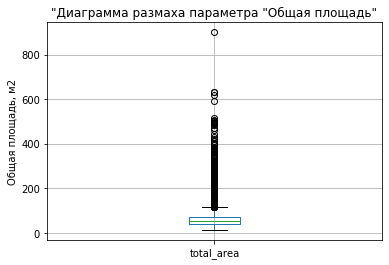

In [699]:
ta_bxp_1 = data.boxplot('total_area')
ta_bxp_1.set_title('"Диаграмма размаха параметра "Общая площадь"')
ta_bxp_1.set_ylabel('Общая площадь, м2')

Верхняя граница уса соответствующая 1.5 межквартильным размахам равна 112.5. Все что выше - считаем выбивающимися значениями

In [700]:
final_data.query('total_area > 112.5').sort_values(by='total_area')['total_area'].count()

210

In [701]:
final_data = final_data.query('total_area < 112.5')

In [702]:
final_data.shape

(21426, 29)

3. Посмотрим на крайние значения у 'rooms':

Text(0, 0.5, 'Количество комнат')

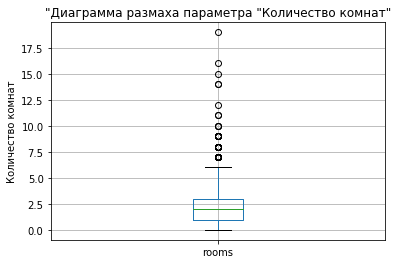

In [703]:
ro_bxp_1 = data.boxplot('rooms')
ro_bxp_1.set_title('"Диаграмма размаха параметра "Количество комнат"')
ro_bxp_1.set_ylabel('Количество комнат')

Все что выше 6 считаем выбросами. Отбросим такие объявления:

In [704]:
data.query('rooms > 6')['rooms'].count()

90

In [705]:
final_data.query('rooms > 6')['rooms'].count()

0

В нашей итоговой таблице таких объявлений и не осталось.

4. Посмотрим крайние значения для выстоты потолка:

Text(0, 0.5, 'Высота потолка, м')

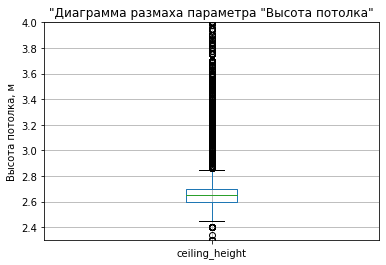

In [706]:
ch_bxp_1 =data.boxplot('ceiling_height')
plt.ylim(2.3, 4)
ch_bxp_1.set_title('"Диаграмма размаха параметра "Высота потолка"')
ch_bxp_1.set_ylabel('Высота потолка, м')

Найдем границы усов вручную:

In [707]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.698721
std          0.253208
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

Получается нам интересны данные в диапазоне 2.45 - 2.85. Все остальное будем считать выбросами:

In [708]:
final_data.query('2.45 > ceiling_height | ceiling_height > 2.85')['ceiling_height'].count()

1885

In [709]:
final_data = final_data.query('2.45 < ceiling_height < 2.85')

In [710]:
final_data.shape

(19443, 29)

5. Общее количество этажей дома. Смотрим крайние:

Text(0, 0.5, 'Общее количкество этажей в доме')

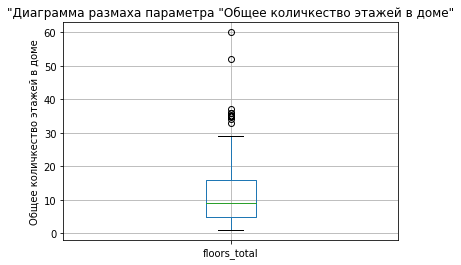

In [711]:
ft_bxp_1 = data.boxplot('floors_total')
ft_bxp_1.set_title('"Диаграмма размаха параметра "Общее количкество этажей в доме"')
ft_bxp_1.set_ylabel('Общее количкество этажей в доме')

Отбросим объявления где общее количество этажей больше 30, остальные оставим:

In [712]:
final_data.query('floors_total > 30')['floors_total'].count()

30

In [713]:
final_data = final_data.query('floors_total < 30')

In [714]:
final_data.shape

(19413, 29)

6. Минимальная жилая площадь - смотрим крайние:

Text(0, 0.5, 'Жилая площадь, м2')

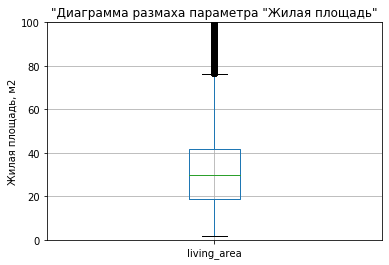

In [715]:
la_bxp_1 = data.boxplot('living_area')
plt.ylim(0, 100)
la_bxp_1.set_title('"Диаграмма размаха параметра "Жилая площадь"')
la_bxp_1.set_ylabel('Жилая площадь, м2')

In [716]:
data['living_area'].describe()

count    23699.000000
mean        34.439309
std         22.226257
min          2.000000
25%         19.000000
50%         30.000000
75%         42.000000
max        409.700000
Name: living_area, dtype: float64

Найдем верхнюю границу уса:

In [717]:
((42 - 19) * 1.5) + 42

76.5

Все что выше этой границы - отбрасываем:

In [718]:
final_data.query('living_area > 76.5')['living_area'].count()

14

In [719]:
final_data = final_data.query('living_area < 76.5')

In [720]:
final_data.shape

(19399, 29)

7. Минимальная площадь кухни - смотрим крайние:

Text(0, 0.5, 'Площадь кухни, м2')

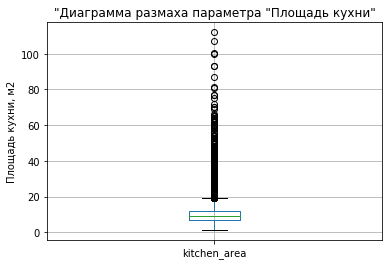

In [721]:
ka_bxp_1 = data.boxplot('kitchen_area')
ka_bxp_1.set_title('"Диаграмма размаха параметра "Площадь кухни"')
ka_bxp_1.set_ylabel('Площадь кухни, м2')

Найдем верхнюю границу уса:

In [722]:
data['kitchen_area'].describe()

count    23699.000000
mean        10.440956
std          5.995644
min          1.300000
25%          7.000000
50%          9.000000
75%         11.976949
max        112.000000
Name: kitchen_area, dtype: float64

In [723]:
((11.97 - 7)*1.5) + 11.97

19.425

Все что выше этой границы - отбрасываем:

In [724]:
final_data.query('kitchen_area > 19.425')['kitchen_area'].count()

330

In [725]:
final_data = final_data.query('kitchen_area < 19.425')

In [726]:
final_data.shape

(19069, 29)

8. Количество дней в публикации - смотрим крайние:

Text(0, 0.5, 'Дней в публикации')

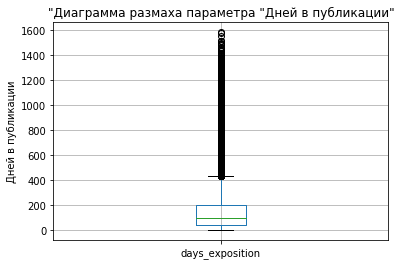

In [727]:
de_bxp_1 = data.boxplot('days_exposition')
de_bxp_1.set_title('"Диаграмма размаха параметра "Дней в публикации"')
de_bxp_1.set_ylabel('Дней в публикации')

Найдем верхнюю границу уса:

In [728]:
data['days_exposition'].describe()

count    23699.000000
mean       169.360226
std        206.535633
min          1.000000
25%         45.000000
50%         95.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [729]:
((199 - 45) * 1.5) + 199

430.0

Все что выше этой границы - отбрасываем:

In [730]:
final_data.query('days_exposition > 430')['days_exposition'].count()

1668

In [731]:
final_data = final_data.query('days_exposition < 430')

In [732]:
final_data.shape

(17391, 29)

9. Цена квадратного метра - смотрим крайние:

Text(0, 0.5, 'Цена квадратного метра, руб.')

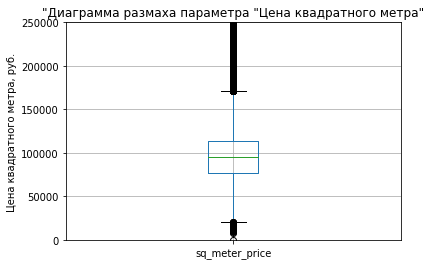

In [733]:
sqm_bxp_1 = data.boxplot('sq_meter_price')
plt.ylim(0, 250000)
sqm_bxp_1.set_title('"Диаграмма размаха параметра "Цена квадратного метра"')
sqm_bxp_1.set_ylabel('Цена квадратного метра, руб.')

Найдем границы усов и отбросим выбивающиеся значения:

In [734]:
data['sq_meter_price'].describe()

count    2.369900e+04
mean     9.942121e+04
std      5.030681e+04
min      1.110000e+02
25%      7.658500e+04
50%      9.500000e+04
75%      1.142560e+05
max      1.907500e+06
Name: sq_meter_price, dtype: float64

In [735]:
qq_2 = (114.256 + ((114.256 - 76.585) * 1.5 )) * 1000

In [736]:
qq_1 = (76.585 - ((114.256 - 76.585) * 1.5 )) * 1000

Посмотрим как много объявлений лежит за этими пределами:

In [737]:
final_data.query('@qq_1 > sq_meter_price | sq_meter_price > @qq_2')['sq_meter_price'].count()

243

In [738]:
final_data = final_data.query('@qq_1 < sq_meter_price < @qq_2')

In [739]:
final_data.shape

(17148, 29)

**Вывод**:для всех важных групп принимающих участие в дальнейшем исследовании нам удалось убрать редкие и выбивающиеся значения.
Так же, мы сформировали итоговый датафрейм для анализа.

#### 5. Задание_3 <a id='step_4_task_5'></a>

**Цель**: "Узнать какие факторы больше всего влияют на стоимость квартиры. Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*.

Для начала, построим матрицу корреляции:

In [740]:
final_data.corr().head()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,weekday,month,year,liv_total_ratio,kit_total_ratio
total_images,1.000000,0.176847,0.114664,0.087770,-0.018357,0.014454,0.103010,0.027696,0.013014,-0.030217,-0.024116,0.064991,0.046109,0.016837,-0.035399,0.016326,-0.027401,-0.003304,0.002440,0.007924,0.127987,-0.013463,0.003958,0.135548,0.018971,-0.039937
last_price,0.176847,1.000000,0.690131,0.434695,0.222241,0.295378,0.567941,0.196028,0.007873,-0.074278,-0.051072,0.499868,0.108175,0.301159,-0.212037,0.182342,-0.209087,0.230690,-0.231361,0.017629,0.615699,-0.004265,0.004892,0.033109,0.027487,-0.161781
total_area,0.114664,0.690131,1.000000,0.807021,0.113319,0.027148,0.913852,0.002891,0.008512,-0.125482,-0.081008,0.479232,0.102997,0.020408,-0.061529,0.012490,-0.020031,0.068383,-0.049344,0.073150,-0.103934,-0.000362,0.007554,-0.036884,0.244862,-0.459985
rooms,0.087770,0.434695,0.807021,1.000000,-0.115488,-0.217008,0.891776,-0.163622,-0.001222,-0.178605,-0.118906,0.085270,0.030774,-0.032285,-0.039616,0.027146,-0.031365,0.012338,-0.006409,0.056219,-0.246357,0.003563,-0.008048,-0.013294,0.551213,-0.662433
ceiling_height,-0.018357,0.222241,0.113319,-0.115488,1.000000,0.335865,-0.014057,0.215059,0.013473,0.052001,0.026598,0.356173,0.074416,0.028688,-0.064224,-0.031925,0.043025,0.046553,-0.036337,0.006211,0.186594,0.007175,0.016084,-0.115900,-0.248955,0.242148


Построим диаграммы рассеяния для каждого из параметров имеющих связь с ценой:

In [741]:
lst_ex = [['total_area', 'График рассеяния. Отношение цены к общей площади', 'Общая площадь, м2'],
         ['sq_meter_price', 'График рассеяния. Отношение цены к цене за квадратный метр', 'Цена за квадратный метр, 10 млн. руб'],
         ['living_area', 'График рассеяния. Отношение цены к жилой площади', 'Жилая площадь, м2'],
         ['rooms', 'График рассеяния. Отношение цены к площади кухни', 'Площадь кухни, м2'],
         ['kitchen_area', 'График рассеяния. Отношение цены к жилой площади', 'Жилая площадь, м2'],
         ['ceiling_height', 'График рассеяния. Отношение цены к высоте потолков', 'Высота потолков, м'],
         ['floors_total', 'График рассеяния. Отношение цены к количеству этажей в доме', 'Количество этажей в доме'],
         ['airports_nearest', 'График рассеяния. Отношение цены к удаленности ближайшего аэропорта', 'Удаленность ближайшего аэропорта, м'],
         ['cityCenters_nearest', 'График рассеяния. Отношение цены к удаленности от центра города', 'Удаленность от центра города, м']]

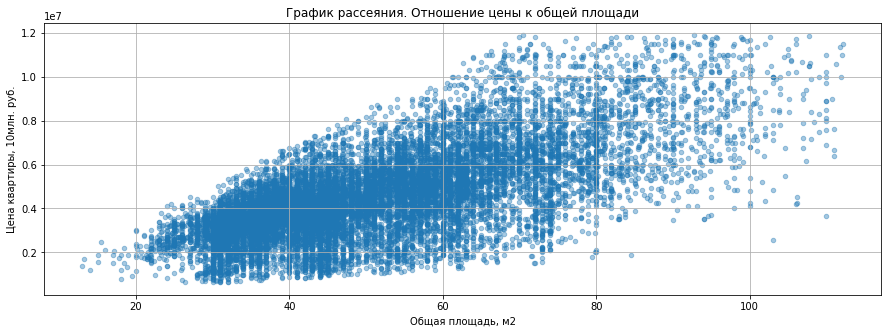

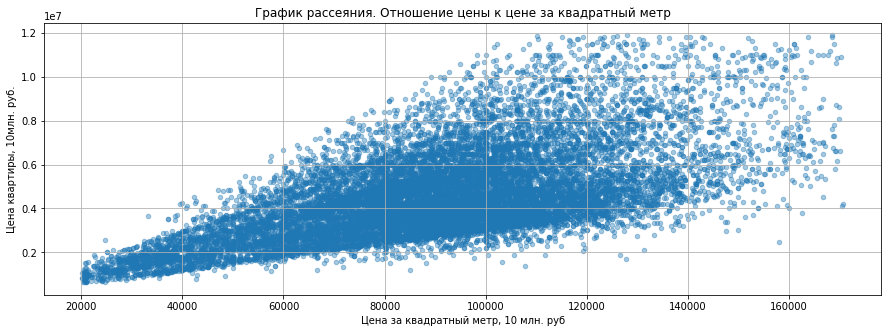

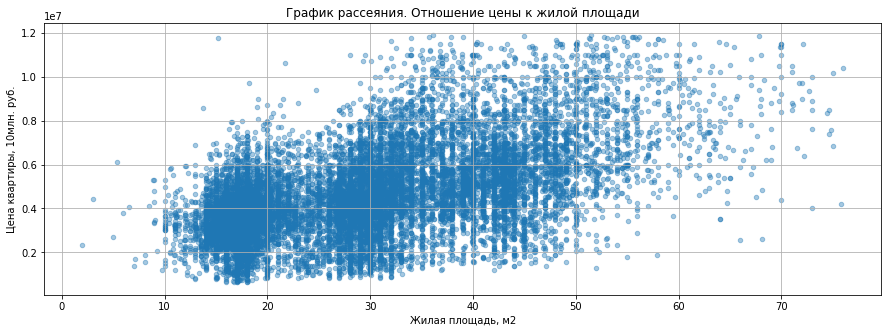

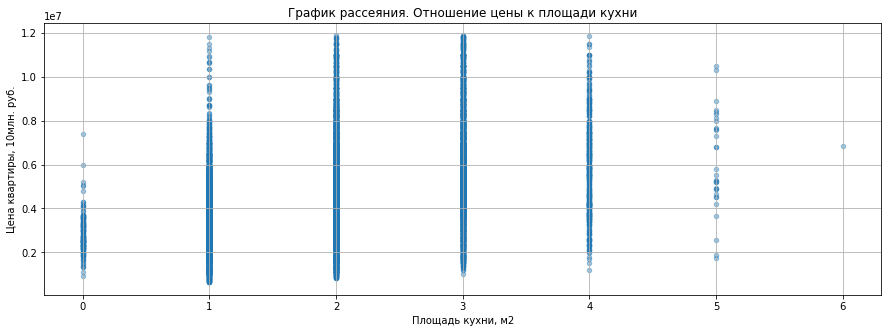

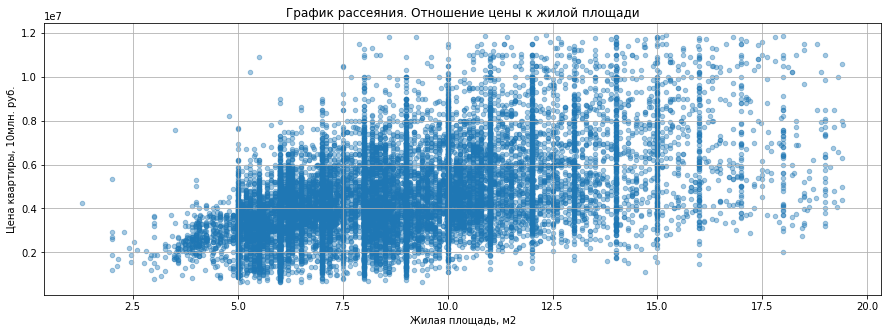

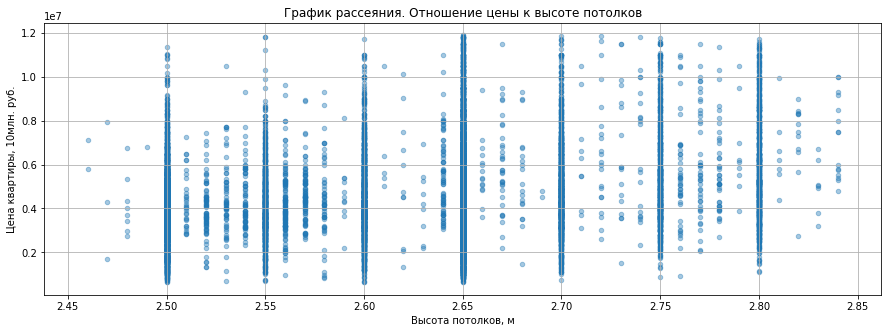

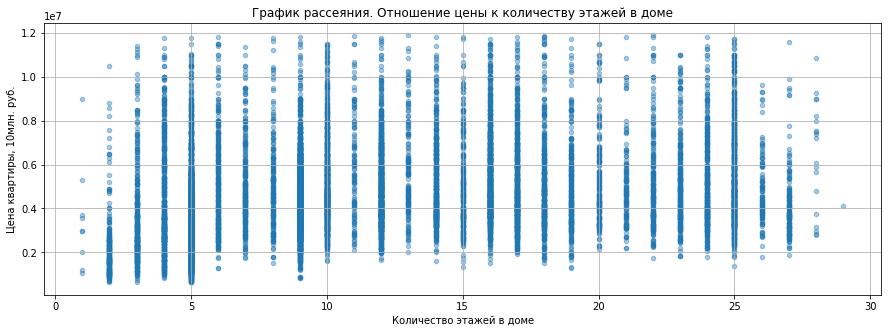

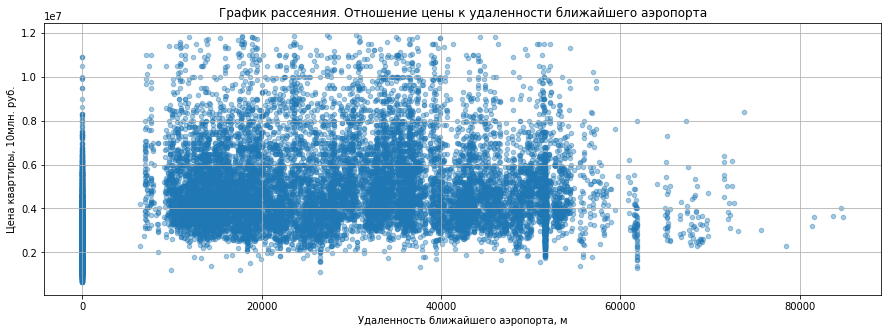

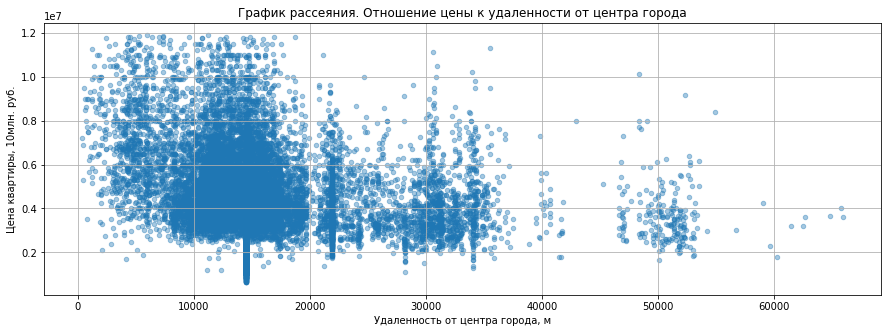

In [742]:
for i in lst_ex:
    scat = final_data.plot(x=i[0], y='last_price', kind='scatter', alpha=0.4, title = i[1], grid=True, figsize=(15, 5))
    scat.set_xlabel(i[2])
    scat.set_ylabel('Цена квартиры, 10млн. руб.')

Здесь мы видим, что итоговая цена имеет:

1. Сильную корреляцию с общей площадью квартиры, ценой квадратного метра

2. Среднюю корреляцию с жилой площадью квартиры, количеством комнат, площадью кухни

3. Слабую корреляцию с высотой потолков, общим количеством этажей в доме, удаленностью аэропорта, близостью к цетру, близостью и количеством рядом парков и водоемов.

Посмотрим как влияет тип этажа на стоимость квартиры:

In [743]:
final_data.pivot_table(index='floor_cat', values='last_price')

,last_price
floor_cat,
Другой,4.742683e+06
Первый,3.841889e+06
Последний,4.074819e+06


Самые дорогие квартиры, обычно, не на первом и не на последнем этажах. Самые дешевые, обычно, на первом.

**Вывод**: Наибольшее влияние на конечную цену квартиры оказывают ее площадь, и стоимость квадратного метра. Чуть меньшее влияние оказывают общая жилая площадь, количество комнат, площадь кухни. Ну и наименьшую роль в значении итоговой цены играют высота потолков, общее количество этажей в доме, удаленность от аэропорта, близость к цетру города, близость и количество рядом парков и водоемов.

Взаимосвязь цены и даты размещения объявления стремиться у нулю. Можно утверждать отсутствие влияния даты размещения на конечную цену.

**Перейдем ко 2 части задания:**

Найдем 10 населенных пунктов с наибоьшим количеством объявлений:

Для этого создадим сводную таблицу из нашей первоначальной

In [744]:
top_cities = data.pivot_table(index='locality_name', values='sq_meter_price', aggfunc=['count', 'mean'])

In [745]:
top_cities.columns = ['count', 'mean']

In [746]:
top_cities.sort_values(by='count', ascending=False).head(10)

,count,mean
locality_name,,
Санкт-Петербург,15721,114848.565231
посёлок Мурино,522,85751.733716
посёлок Шушары,440,78676.904545
Всеволожск,398,68654.007538
Пушкин,369,103125.373984
Колпино,338,75424.150888
посёлок Парголово,327,90175.489297
Гатчина,307,68745.693811
деревня Кудрово,299,92473.086957


Мы получили таблицу отсортированную по количеству объявлений. Как можно видеть - лидирует Санкт-Петербург, а замыкает топ-10 город Выборг.

Ситуация с ценой на квадратный метр для этих городов аналогична. Город с самой высокой ценой за квадратный метр - Санкт-Петербург. А самую дешевую недвижимость можно найти в городе Выборг.

Осталось найти населенные пункты с самой высокой и самой низкой стоимостью жилья в Ленинрадской области в целом:

In [747]:
top_cities.sort_values(by='mean', ascending=False).head(1)

,count,mean
locality_name,,
посёлок Лисий Нос,2,121615.5


In [748]:
top_cities.sort_values(by='mean', ascending=False).tail(1)

,count,mean
locality_name,,
деревня Старополье,3,11206.0


**Вывод**: самая дорогая недвижимость в Ленинградской области расположена в поселке Лисий нос, а самая дешевая в деревне Старополье.

#### 7. Задание_4<a id='step_4_task_6'></a>

**Цель**: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "

Выделим квартиры, которые расположены в Санкт-Петербурге:

In [749]:
data_spb = final_data.query('locality_name == "Санкт-Петербург"')

Добавим столбец, где укажем целое число километров до центра для каждой квартиры

In [750]:
data_spb['kilometers'] = data_spb['cityCenters_nearest'] // 1000 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [751]:
data_spb

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,weekday,month,year,floor_cat,liv_total_ratio,kit_total_ratio,kilometers
7,5,7915000,71.6,2019-04-18,2,2.65,24,38.702703,22,False,False,False,18.9,2,Санкт-Петербург,23982,11634,0,3100,0,3100,95,110544,4,4,2019,Другой,0.540541,0.263966,11
9,18,5400000,61.0,2017-02-26,3,2.50,9,43.600000,7,False,False,False,6.5,2,Санкт-Петербург,50898,15008,0,3100,0,3100,289,88524,7,2,2017,Другой,0.714754,0.106557,15
10,5,5050000,39.6,2017-11-16,1,2.67,12,20.300000,3,False,False,False,8.5,0,Санкт-Петербург,38357,13878,1,310,2,553,137,127525,4,11,2017,Другой,0.512626,0.214646,13
15,16,4650000,39.0,2017-11-18,1,2.65,14,20.500000,5,False,False,False,7.6,1,Санкт-Петербург,12900,14259,1,590,1,296,19,119230,6,11,2017,Другой,0.525641,0.194872,14
18,8,3250000,31.0,2017-01-27,1,2.50,5,19.400000,2,False,False,False,5.6,1,Санкт-Петербург,44060,10842,1,759,0,3100,168,104838,5,1,2017,Другой,0.625806,0.180645,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23680,14,5000000,59.0,2019-04-04,3,2.50,5,52.000000,1,False,False,False,7.0,0,Санкт-Петербург,26835,11878,0,3100,0,3100,95,84745,4,4,2019,Первый,0.881356,0.118644,11
23681,13,5250000,43.0,2018-05-11,2,2.50,5,29.000000,2,False,False,False,6.0,0,Санкт-Петербург,28323,7262,1,497,2,660,80,122093,5,5,2018,Другой,0.674419,0.139535,7
23686,8,3300000,31.0,2017-04-29,1,2.55,9,18.000000,6,False,False,False,6.5,0,Санкт-Петербург,11751,11602,1,140,1,317,193,106451,6,4,2017,Другой,0.580645,0.209677,11
23687,6,3200000,39.0,2017-12-16,1,2.65,9,20.000000,6,False,False,False,11.0,2,Санкт-Петербург,40837,16704,0,3100,0,3100,38,82051,6,12,2017,Другой,0.512821,0.282051,16


Создадим свобную таблицу, где найдем среднюю цену для каждого километра.

In [752]:
data_spb_pivot = data_spb.pivot_table(index='kilometers', values=['last_price', 'sq_meter_price'])

In [753]:
data_spb_pivot

,last_price,sq_meter_price
kilometers,,
0,7.557933e+06,111068.400000
1,7.829975e+06,115522.125000
2,6.972411e+06,114263.214286
3,6.599462e+06,109165.219512
4,7.165392e+06,118656.702703
5,6.815885e+06,117085.958678
6,6.546693e+06,120912.388235
7,6.439376e+06,116371.034483
8,5.550054e+06,109299.265487


In [754]:
data_spb_pivot

,last_price,sq_meter_price
kilometers,,
0,7.557933e+06,111068.400000
1,7.829975e+06,115522.125000
2,6.972411e+06,114263.214286
3,6.599462e+06,109165.219512
4,7.165392e+06,118656.702703
5,6.815885e+06,117085.958678
6,6.546693e+06,120912.388235
7,6.439376e+06,116371.034483
8,5.550054e+06,109299.265487


Уже здесь заметно, что после 7 километра происходит резкое снижение стоимости квартир на миллион в среднем, а средняя цена за квадратный метр опускается ниже 110 тыс. руб.

Построим график распределения цен в зависимости от километра:

Text(0, 0.5, 'Цена квартиры, руб')

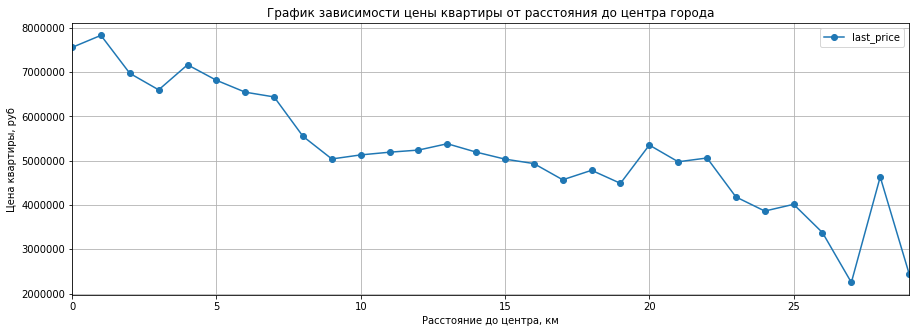

In [755]:
price_center = data_spb_pivot.plot(y='last_price', style='o-', title='График зависимости цены квартиры от расстояния до центра города', grid=True, figsize=(15, 5))
price_center.set_xlabel('Расстояние до центра, км')
price_center.set_ylabel('Цена квартиры, руб')

**Вывод**: Примерно на расстоянии 7 километров от центра - цена на квартиры резко уменьшается. 7 километров - можно считать границей центральной зоны.

#### 7. Задание_5 <a id='step_4_task_7'></a>

**Цель**: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"

Для ответа на поставленные вопросы ипользовать датафрейм data_spb нельзя. Потому, что суммарное количество объявлений находящихся в пределах 7км от центра города - больше 3000. Значит, в итоговой выборке по Санкт-Петербургу которой мы пользовались выше, - осталось меньше 40% объявлений. Большинство квартир, находящихся в центре являются нетиповыми: с высокими потолками, ценой сильно выше рыночной, большой общей площадью и т.д. Поэтому в нашу выборку выше они не попали. Но для ответа на поставленные сейчас вопросы - такие квартиры обязательно нужно учитывать.

Создадим новую таблицу spb_center куда включим объявления подходящие по выявленным ранее параметрам:

In [756]:
data['kilometers'] = data['cityCenters_nearest'] // 1000 

In [757]:
spb_center = data.query('locality_name == "Санкт-Петербург" & kilometers < 7')

Посмотрим на описание получившегося датафрейма:

In [758]:
spb_center.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,weekday,month,year,liv_total_ratio,kit_total_ratio,kilometers
count,3305.000000,3.305000e+03,3305.000000,3305.000000,3305.000000,3305.000000,3305.000000,3305.000000,3305.000000,3305.000000,3305.000000,3305.000000,3305.000000,3305.000000,3305.000000,3305.000000,3305.000000,3.305000e+03,3305.000000,3305.000000,3305.000000,3305.000000,3305.000000,3305.000000
mean,10.145234,1.496753e+07,94.192887,2.861422,2.951710,6.897126,55.435701,4.089864,14.740420,0.305598,24559.353707,4345.640847,1.048109,1349.401210,1.295613,1200.579123,224.842057,1.447745e+05,3.499849,6.423903,2017.173071,0.578958,0.171868,3.850227
std,5.983894,2.466922e+07,60.206984,1.469065,0.378024,3.642757,38.459234,2.823946,9.556008,0.746125,3833.225559,1550.863041,0.954369,1267.576939,1.098396,1203.534837,259.561981,9.387552e+04,1.712567,3.468080,1.127604,0.111815,0.079409,1.542857
min,0.000000,1.600000e+06,12.000000,0.000000,2.400000,2.000000,2.000000,1.000000,1.957586,0.000000,15359.000000,181.000000,0.000000,9.000000,0.000000,22.000000,3.000000,1.534500e+04,1.000000,1.000000,2014.000000,0.021583,0.025381,0.000000
25%,6.000000,6.700000e+06,57.700000,2.000000,2.650000,5.000000,31.729730,2.000000,9.000000,0.000000,21869.000000,3405.000000,0.000000,363.000000,0.000000,315.000000,71.000000,9.943700e+04,2.000000,3.000000,2017.000000,0.523810,0.119728,3.000000
50%,10.000000,9.300000e+06,80.000000,3.000000,2.840000,6.000000,46.500000,4.000000,12.000000,0.000000,24202.000000,4599.000000,1.000000,600.000000,1.000000,618.000000,97.000000,1.235290e+05,4.000000,6.000000,2017.000000,0.583333,0.158967,4.000000
75%,15.000000,1.450000e+07,110.600000,4.000000,3.170000,8.000000,67.010000,5.000000,17.000000,0.000000,26591.000000,5483.000000,2.000000,3100.000000,2.000000,3100.000000,293.000000,1.559760e+05,5.000000,10.000000,2018.000000,0.658740,0.196721,5.000000
max,50.000000,7.630000e+08,631.200000,19.000000,6.000000,25.000000,409.000000,25.000000,107.000000,5.000000,39465.000000,6998.000000,3.000000,3100.000000,3.000000,3100.000000,1572.000000,1.907500e+06,7.000000,12.000000,2019.000000,0.983447,0.636986,6.000000


Построим гистограммы для каждого из признаков: площадь, цена, число комнат, высота потолков:

**Цена квартир**

Text(0, 0.5, 'Частота встречаемости')

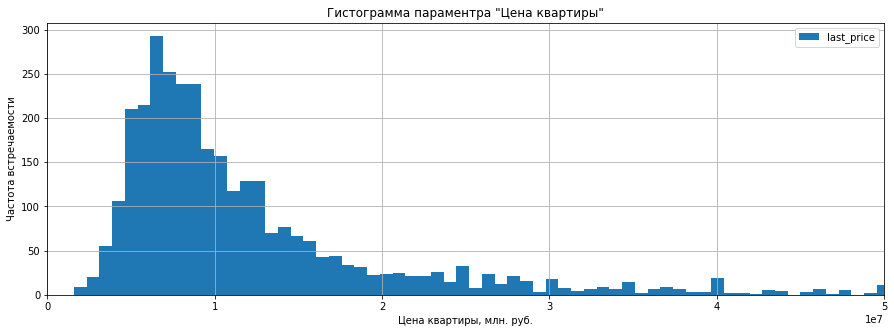

In [759]:
price_center = spb_center.plot(y='last_price', kind='hist', bins=1000, xlim=(0, 5e7), title='Гистограмма параментра "Цена квартиры"', grid=True, figsize=(15, 5))
price_center.set_xlabel('Цена квартиры, млн. руб.')
price_center.set_ylabel('Частота встречаемости')

Мы видим, что основная масса квартир продается по цене 5 - 15 млн. руб.

**Площадь квартир**

Text(0, 0.5, 'Частота встречаемости')

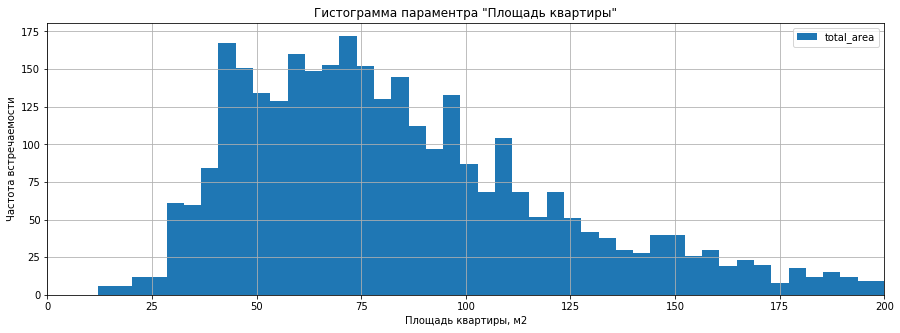

In [760]:
price_center = spb_center.plot(y='total_area', kind='hist', bins=150, xlim=(0, 200), title='Гистограмма параментра "Площадь квартиры"', grid=True, figsize=(15, 5))
price_center.set_xlabel('Площадь квартиры, м2')
price_center.set_ylabel('Частота встречаемости')

Больше всего квартир площадью от 30 до 125 м2

**Число комнат**

Text(0, 0.5, 'Частота встречаемости')

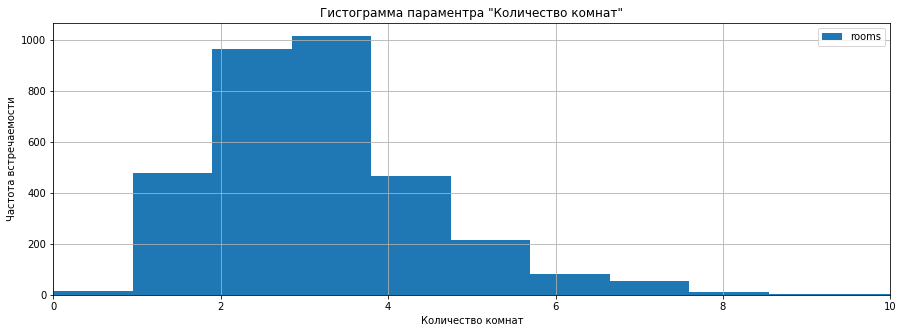

In [761]:
price_center = spb_center.plot(y='rooms', kind='hist', bins=20, xlim=(0, 10), title='Гистограмма параментра "Количество комнат"', grid=True, figsize=(15, 5))
price_center.set_xlabel('Количество комнат')
price_center.set_ylabel('Частота встречаемости')

Больше всего квартир имеющих 1 - 4 комнаты

**Высота потолков**

Text(0, 0.5, 'Частота встречаемости')

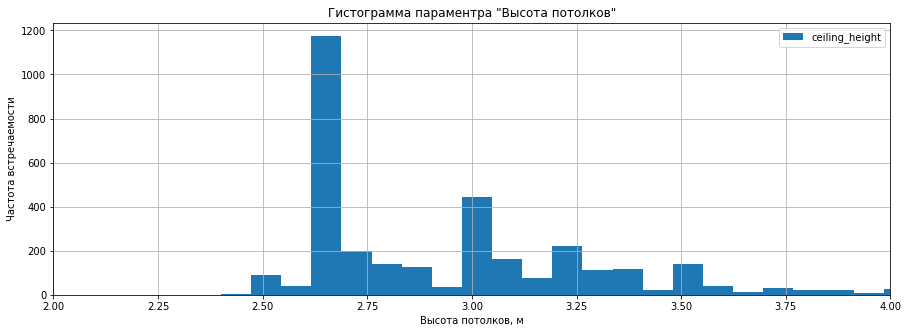

In [762]:
price_center = spb_center.plot(y='ceiling_height', kind='hist', bins=50, xlim=(2, 4), title='Гистограмма параментра "Высота потолков"', grid=True, figsize=(15, 5))
price_center.set_xlabel('Высота потолков, м')
price_center.set_ylabel('Частота встречаемости')

В среднем, высота потолков составляет 2.65 для большинства объявлений. Но это может быть связано с заполнением ранее пропусков медианным значением. Так же видно, что около 500 квартир имеют высоту потолка равную 3м.

Посмотрим, какие факторы в большей степени влияют на цену квартиры в центре Санкт-Петербурга. Построим матрицу корреляции:

In [763]:
spb_center.corr()['last_price']

total_images           0.135332
last_price             1.000000
total_area             0.607578
rooms                  0.309873
ceiling_height         0.145245
floors_total           0.045747
living_area            0.536045
floor                  0.122465
is_apartment           0.038890
studio                -0.022285
open_plan              0.002514
kitchen_area           0.476733
balcony                0.077933
airports_nearest       0.092191
cityCenters_nearest   -0.042324
parks_around3000       0.104651
parks_nearest         -0.051874
ponds_around3000       0.090362
ponds_nearest         -0.059827
days_exposition        0.042570
sq_meter_price         0.794463
weekday                0.028178
month                 -0.011148
year                  -0.039843
liv_total_ratio       -0.012770
kit_total_ratio       -0.077655
kilometers            -0.047106
Name: last_price, dtype: float64

In [764]:
lst_exam = [['total_area', 'График рассеяния. Отношение цены к общей площади', 'Общая площадь, м2'],
         ['sq_meter_price', 'График рассеяния. Отношение цены к цене за квадратный метр', 'Цена за квадратный метр, 10 млн. руб'],
         ['living_area', 'График рассеяния. Отношение цены к жилой площади', 'Жилая площадь, м2'],
         ['rooms', 'График рассеяния. Отношение цены к площади кухни', 'Площадь кухни, м2'],
         ['kitchen_area', 'График рассеяния. Отношение цены к жилой площади', 'Жилая площадь, м2'],
         ['ceiling_height', 'График рассеяния. Отношение цены к высоте потолков', 'Высота потолков, м'],
         ['floors_total', 'График рассеяния. Отношение цены к количеству этажей в доме', 'Количество этажей в доме'],
         ['airports_nearest', 'График рассеяния. Отношение цены к удаленности ближайшего аэропорта', 'Удаленность ближайшего аэропорта, м'],
         ['cityCenters_nearest', 'График рассеяния. Отношение цены к удаленности от центра города', 'Удаленность от центра города, м']]

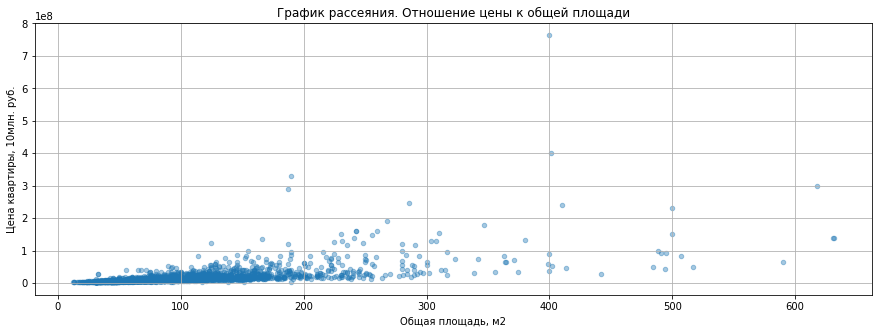

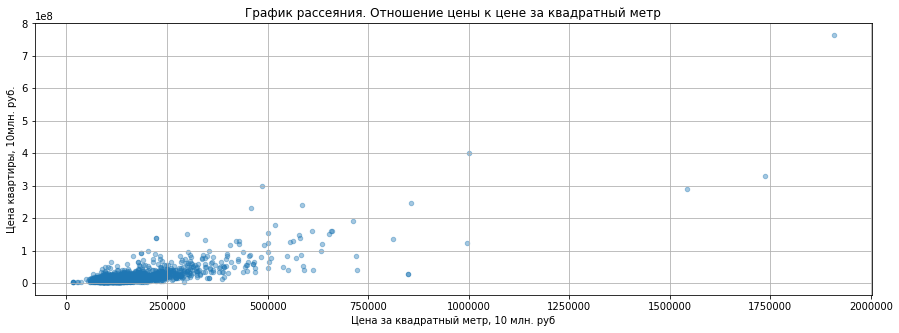

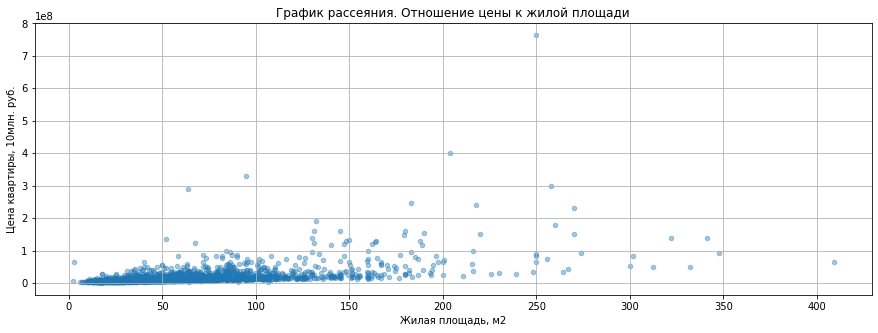

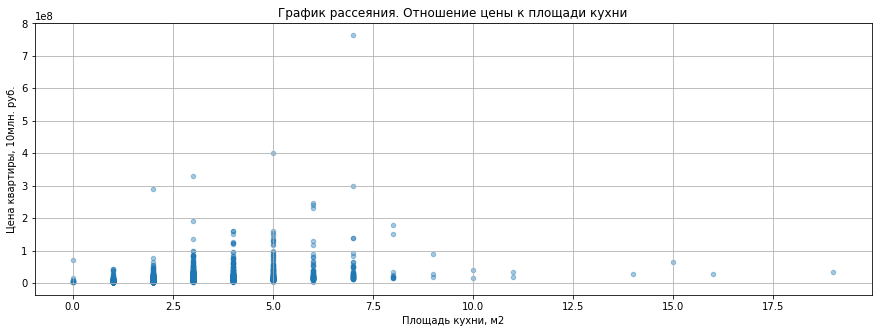

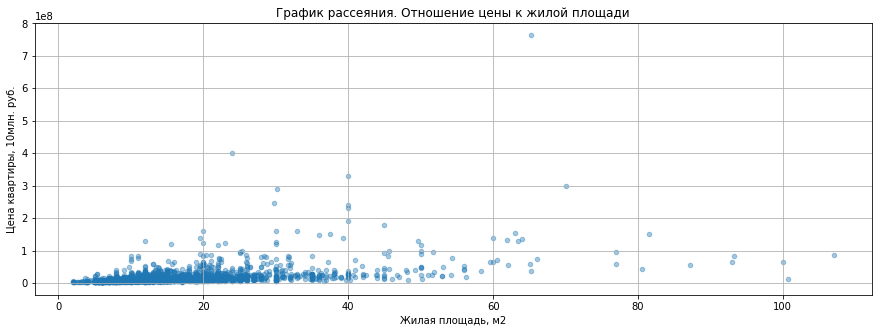

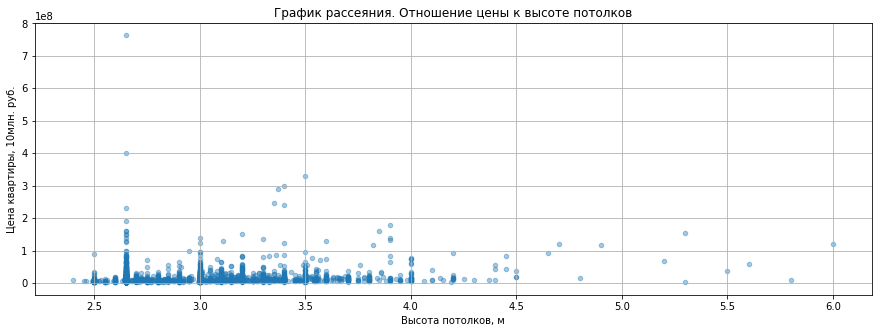

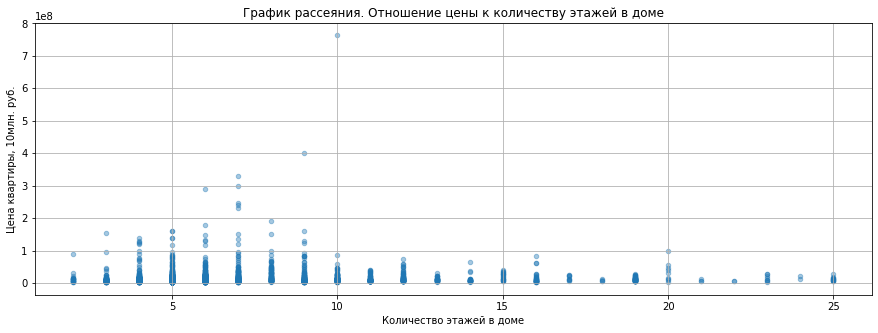

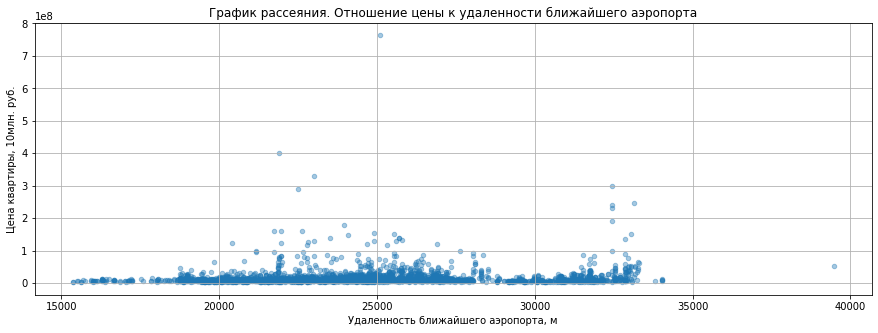

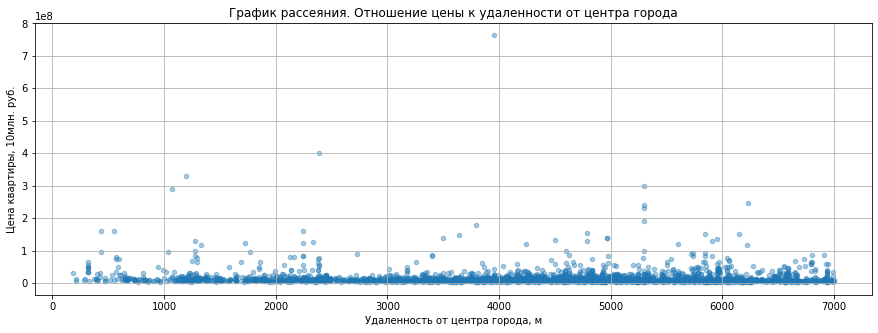

In [765]:
for i in lst_exam:
    scat = spb_center.plot(x=i[0], y='last_price', kind='scatter', alpha=0.4, title = i[1], grid=True, figsize=(15, 5))
    scat.set_xlabel(i[2])
    scat.set_ylabel('Цена квартиры, 10млн. руб.')


**Вывод:** Наиболее сильно на итоговую стоимоть квартиры влияют такие параметры как: общая площадь и цена за квадратный метр. В меньшей степени - жилая площадь, площадь кухни. Ну и совсем малую часть вносит параметр количество комнат. Влияния на цену даты размещения объявления, расстояния до центра города, этажа - не выявлено.

Посмотрим теперь, отличаются ли квартиры в центре от тех что расположены в остальной части города. 

Построим датафрейм для квартир находящихся НЕ в центре.

In [766]:
suburb_spb = data.query('locality_name == "Санкт-Петербург" & kilometers > 7')

In [767]:
suburb_spb

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,weekday,month,year,floor_cat,liv_total_ratio,kit_total_ratio,kilometers
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,95,120370,4,3,2019,Другой,0.472222,0.231481,16
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.300000,4,False,False,False,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558,92785,4,8,2015,Другой,0.612500,0.148214,13
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2,112,1,48,121,100000,2,6,2018,Другой,0.320000,0.410000,8
7,5,7915000,71.60,2019-04-18,2,2.65,24,38.702703,22,False,False,False,18.9,2,Санкт-Петербург,23982,11634,0,3100,0,3100,95,110544,4,4,2019,Другой,0.540541,0.263966,11
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.600000,7,False,False,False,6.5,2,Санкт-Петербург,50898,15008,0,3100,0,3100,289,88524,7,2,2017,Другой,0.714754,0.106557,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,8,3300000,31.00,2017-04-29,1,2.55,9,18.000000,6,False,False,False,6.5,0,Санкт-Петербург,11751,11602,1,140,1,317,193,106451,6,4,2017,Другой,0.580645,0.209677,11
23687,6,3200000,39.00,2017-12-16,1,2.65,9,20.000000,6,False,False,False,11.0,2,Санкт-Петербург,40837,16704,0,3100,0,3100,38,82051,6,12,2017,Другой,0.512821,0.282051,16
23688,19,9200000,101.00,2019-04-01,3,3.05,15,63.000000,12,False,False,False,15.0,0,Санкт-Петербург,15632,14428,0,3100,0,3100,23,91089,1,4,2019,Другой,0.623762,0.148515,14
23689,13,3550000,35.30,2018-02-28,1,2.86,15,16.300000,4,False,False,False,9.1,2,Санкт-Петербург,17284,16081,1,353,2,652,29,100566,3,2,2018,Другой,0.461756,0.257790,16


Посмотрим как отличаются цены на квартиры:

Text(0, 0.5, 'Частота встречаемости')

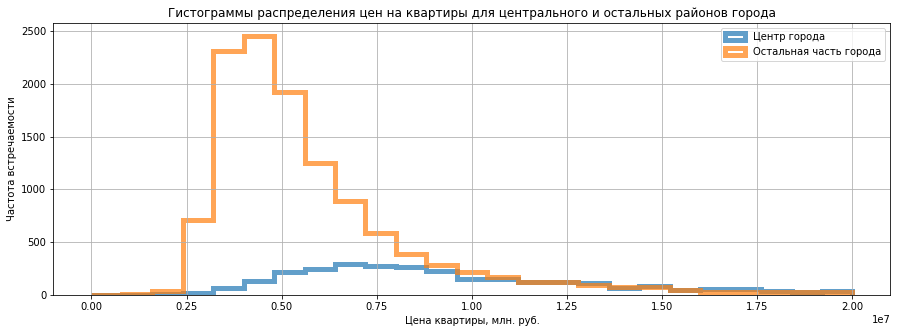

In [768]:
ax = spb_center.plot(kind='hist', y='last_price', histtype='step', range=(0, 2e7), bins=25, linewidth=5, alpha=0.7, label='Центр города', figsize=(15, 5))
suburb_spb.plot(kind='hist', y='last_price', histtype='step', range=(0, 2e7), bins=25, linewidth=5, alpha=0.7, label='Остальная часть города', ax=ax, grid=True, legend=True)
ax.set_title('Гистограммы распределения цен на квартиры для центрального и остальных районов города')
ax.set_xlabel('Цена квартиры, млн. руб.')
ax.set_ylabel('Частота встречаемости')

На графике видно, что цены в центре в среднем дороже на несколько млн. руб.

Посмотрим как отличаются площади квартир:

Text(0, 0.5, 'Частота встречаемости')

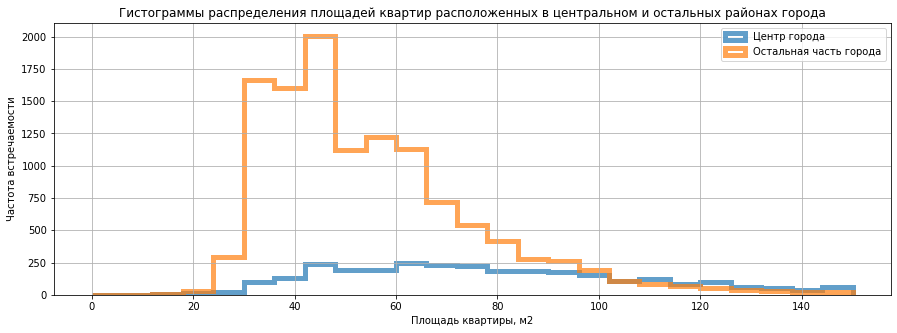

In [769]:
ax = spb_center.plot(kind='hist', y='total_area', histtype='step', range=(0, 150), bins=25, linewidth=5, alpha=0.7, label='Центр города', figsize=(15, 5))
suburb_spb.plot(kind='hist', y='total_area', histtype='step', range=(0, 150), bins=25, linewidth=5, alpha=0.7, label='Остальная часть города', ax=ax, grid=True, legend=True)
ax.set_title('Гистограммы распределения площадей квартир расположенных в центральном и остальных районах города')
ax.set_xlabel('Площадь квартиры, м2')
ax.set_ylabel('Частота встречаемости')

За пределами центра Петербурга квартиры в среднем имеют площадь 30-70 м2. В центре 30 - 120. В центре разброс гораздо выше.

Посмотрим как отличается высота потолков:

Text(0, 0.5, 'Частота встречаемости')

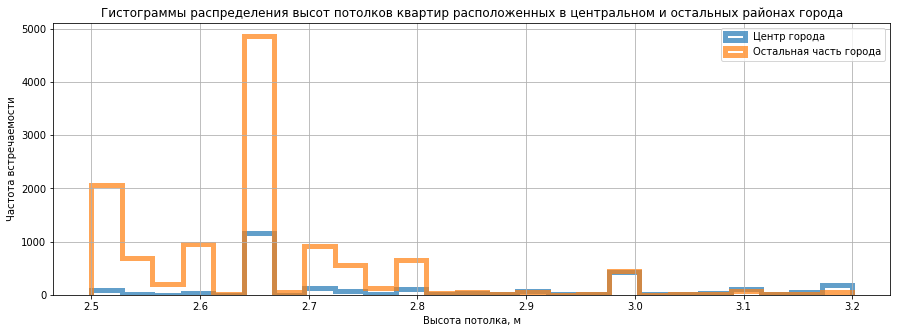

In [770]:
ax = spb_center.plot(kind='hist', y='ceiling_height', histtype='step', range=(2.5, 3.2), bins=25, linewidth=5, alpha=0.7, label='Центр города', figsize=(15, 5))
suburb_spb.plot(kind='hist', y='ceiling_height', histtype='step', range=(2.5, 3.2), bins=25, linewidth=5, alpha=0.7, label='Остальная часть города', ax=ax, grid=True, legend=True)
ax.set_title('Гистограммы распределения высот потолков квартир расположенных в центральном и остальных районах города')
ax.set_xlabel('Высота потолка, м')
ax.set_ylabel('Частота встречаемости')

Ситуации практически идентичны. Большое количество квартир с высотой потолка 2.65 связано с заполнением знечений. В процентном соотношеннии к общему количеству квартир в каждой из рассматриваемых областей - в центре города гораздо больше квартир имеющих высоту потолка 3 и более метров.

Посмотрим как отличается число комнат:

Text(0, 0.5, 'Частота встречаемости')

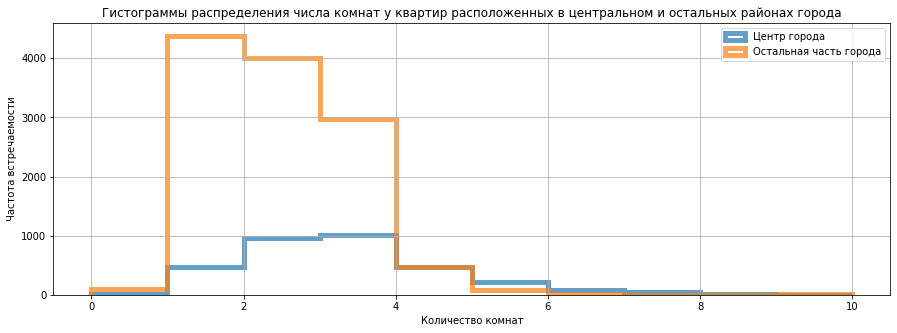

In [771]:
ax = spb_center.plot(kind='hist', y='rooms', histtype='step', range=(0, 10), bins=10, linewidth=5, alpha=0.7, label='Центр города', figsize=(15, 5))
suburb_spb.plot(kind='hist', y='rooms', histtype='step', range=(0, 10), bins=10, linewidth=5, alpha=0.7, label='Остальная часть города', ax=ax, grid=True, legend=True)
ax.set_title('Гистограммы распределения числа комнат у квартир расположенных в центральном и остальных районах города')
ax.set_xlabel('Количество комнат')
ax.set_ylabel('Частота встречаемости')

В среднем, в центре города преобладают квартиры 2-4 комнаты, тогда как в остальных районах 1-3 комнаты.

**Вывод**: В ходе анализа сегмента квартир расположенных в центре города было выявлено:

1. Цена на квартиру зависит от тех же параметров что и в любой другой части города.
2. Цены на квартиры в центре города в среднем на несколько миллионов больше цен на квартиры из других районов.
3. Площади квартир в центре города находятся в диапазоне 30-120м2. Тогда как в остальной части преобладают более маленькие 30-70м2.
4. Высота потолков в центре выше. Большая часть квартир имеет высоту потолка более 3м. 
5. Квартиры в центре имеют в больше комнат. В среднем на 1 одну комнату больше.

### Шаг 5. Общий вывод

В ходе работы над проектом мной была проделана следующая работа:

1. Предобработаны данные. Заполнены пропуски, найдены большинство причин их появления.
2. Данные избавлены от аномальных и выбивающихся значений.
3. Проанализированы получившиеся данные. 

**Вывод** по результатам анализа данных: нельзя выбрасывать данные просто так. Несмотря на то, что данные находятся за пределами усов боксплота - они могут представлять ключевую значимость для результатов исследования. Такие данные могут представлять целый отдельный кластер, который может подчиняться другим законам, нежели основной массив. 

